# タスクの概要

**目標**　患者の11の特徴から心臓病か否かを分類する。

データは、`data`ディレクトリに`train.csv`, `test.csv`という名前のデータがあります。記録されている特徴量は以下のとおりです。学習モデルを作るときには、`train.csv`のみを用いてよいものとします。以下の2つのことに挑戦してください。

1. 心臓病になりやすい患者さんとはどんなひとかを説明してください。
2. デモでみせるモデルよりも`test.csv`の上で精度の高いモデルを作ってください。

* Age : 患者の年齢
* Sex : 患者の性別
    * `1`は男性, `0`は女性
* ChestPainType : 筋痛の種類
    * `TA`は典型的狭心症, `ATA`は非典型狭心症, `NAP`は非狭心症の痛み, `ASY`は無症状
* RestingBP : 安静時血圧
* Cholesterol : 血清コレステロール値
* FastingBS : 空腹時血糖値
    * `1`は~FastingBS>1~`>120 mg/dl`, `0`はそれ以外
* RestingECG : 安静時心電図結果
    * `Normal`は正常, `ST`はST-T波に異常, `LVH`は左心室肥大の可能性・確定
* MaxHR : 到達最大心拍数
* ExerciseAngina : 運動誘発性狭心症
    * `1`はあり, `0`はなし
* Oldpeak : ~うつ状態で測定された数値~　安静時と比較して運動により誘発されたST低下
* ST_Slope : 運動時のSTピークセグメントの動き。低下した上でupslopingというのもあるっぽい。
    * `Up`はupsloping, `flat`は平坦, `Down`はdownsloping

心臓病かいなかは`HeartDisease`に`1`が心臓病, `0`が正常として記録されています。

# import

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import FactorAnalysis as FA
from sklearn.ensemble  import HistGradientBoostingClassifier


np.set_printoptions(linewidth=200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

# 前処理(冗長な列をdropする、説明変数をdropする、dropna()、train_test_split()

In [2]:
# 前処理関数
def prepro(cols='df.columns', drop_Cholesterol=True, drop_na=True, drop_multico=False):
    df = df1.copy()
    
    # 説明変数を決める
    # Cholesterol列をdropするか否か(デフォルト: dropする)
    if drop_Cholesterol == True:
        df = df.drop(columns=['Cholesterol'])
    elif drop_na == True: # Cholesterol列をdropしない場合、NaNを含む行はdropするか否か(デフォルト: dropする)
        df = df.dropna()
        print('NaNを含む行をdropしました。')
    else:
        print('Cholesterol列もNaNを含む行も残っています。')
        
    # 冗長な列をdropするか(デフォルト: dropしない)
    if drop_multico == True:
        df = df.drop(columns=['ChestPainType_TA', 'RestingECG_ST', 'ST_Slope_Down'])
        print('冗長な列をdropしました。')

        
    # 目的変数を決める
    y = df['HeartDisease']
    
    # 説明変数を選ぶ(デフォルト: 全て使う(Cholesterol列を使うか否かはdrop_Cholesterolの値に依存する))
    if cols == 'df.columns':
        cols = df.columns
    X = df[cols].drop(columns='HeartDisease')
    cols_used = np.array(cols[1:])
    
    # 標準化する
    sscaler = StandardScaler()
    X_ss = sscaler.fit_transform(X)

    # 学習用データとテスト用データに分ける
    X_train, X_test, X_train_ss, X_test_ss, y_train, y_test = train_test_split(X.values, X_ss, y.values, test_size=0.2, stratify=y, random_state=1)
    print('X_train.shape:', X_train.shape)
    print('X_test.shape:', X_test.shape)

    return cols_used, X_train, y_train, X_train_ss, X_test, y_test, X_test_ss

# データの概観

In [3]:
df_orig = pd.read_csv('./data/train.csv')

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,56,1,ASY,155,342,1,Normal,150,1,3.0,Flat,1
1,55,0,ATA,130,394,0,LVH,150,0,0.0,Up,0
2,47,1,NAP,110,0,1,Normal,120,1,0.0,Flat,1
3,34,1,ASY,115,0,1,Normal,154,0,0.2,Up,1
4,54,0,NAP,160,201,0,Normal,163,0,0.0,Up,0


1    0.55919
0    0.44081
Name: HeartDisease, dtype: float64

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


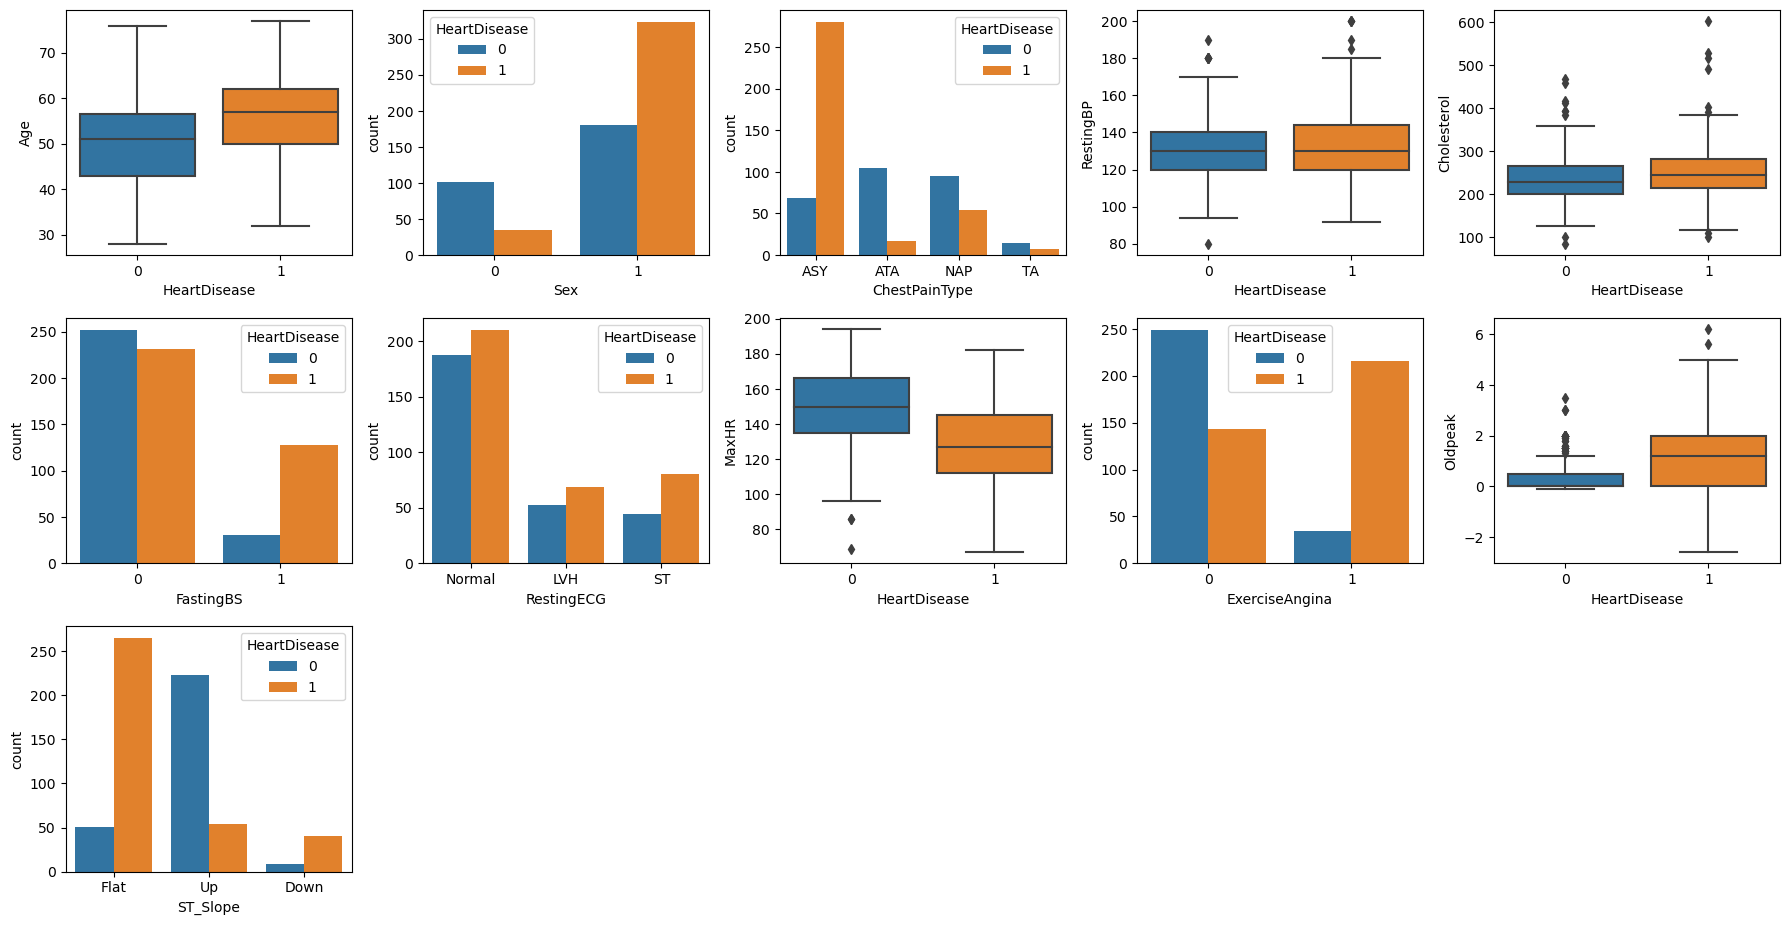

,HeartDisease,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,1,56,1,155,342.0,1,150,1,3.0,1,0,0,0,0,1,0,0,1,0
1,0,55,0,130,394.0,0,150,0,0.0,0,1,0,0,1,0,0,0,0,1
2,1,47,1,110,NaN,1,120,1,0.0,0,0,1,0,0,1,0,0,1,0
3,1,34,1,115,NaN,1,154,0,0.2,1,0,0,0,0,1,0,0,0,1
4,0,54,0,160,201.0,0,163,0,0.0,0,0,1,0,0,1,0,0,0,1


(642, 19)
HeartDisease           0
Age                    0
Sex                    0
RestingBP              0
Cholesterol          123
FastingBS              0
MaxHR                  0
ExerciseAngina         0
Oldpeak                0
ChestPainType_ASY      0
ChestPainType_ATA      0
ChestPainType_NAP      0
ChestPainType_TA       0
RestingECG_LVH         0
RestingECG_Normal      0
RestingECG_ST          0
ST_Slope_Down          0
ST_Slope_Flat          0
ST_Slope_Up            0
dtype: int64


In [4]:
df0 = df_orig.copy()
display(df0.head())

display(df0['HeartDisease'].value_counts(dropna=False, normalize=True))

print(df0.isna().sum())

# Cholesterol列の0をNaNに変換する
df0.loc[df0['Cholesterol'] == 0, 'Cholesterol'] = np.nan

# 良性/悪性で分けた箱ヒゲ図を描く(カテゴリ変数の場合棒グラフを描く)
fig =plt.figure(figsize=[18,12])
for i in range(0, df0.shape[1]-1):
    axi = plt.subplot(4, 5, i+1)
    if len(set(df0.iloc[:, i])) <=4:
        # sns.boxplot(data=df0, y=df0.iloc[:, -1], x=df0.iloc[:, i], ax=axi)
        sns.countplot(data=df0.iloc[:, [-1, i]], x=df0.columns[i], hue='HeartDisease', ax=axi)
    else:
        sns.boxplot(data=df0, x=df0.iloc[:, -1], y=df0.iloc[:, i], ax=axi)
    plt.tight_layout() # 体裁をきれいにするおまじない
plt.show()

# One-Hotエンコーディングする(冗長な列も残しておく)
df0_y = df0['HeartDisease'] # 目的変数を一旦避難させる
df1 = df0.drop(columns='HeartDisease')
df1 = pd.get_dummies(df1, drop_first=False)
df1.insert(loc=0, column='HeartDisease', value=df0_y) # 目的変数を先頭に結合する

display(df1.head())
print(df1.shape)

print(df1.isna().sum())

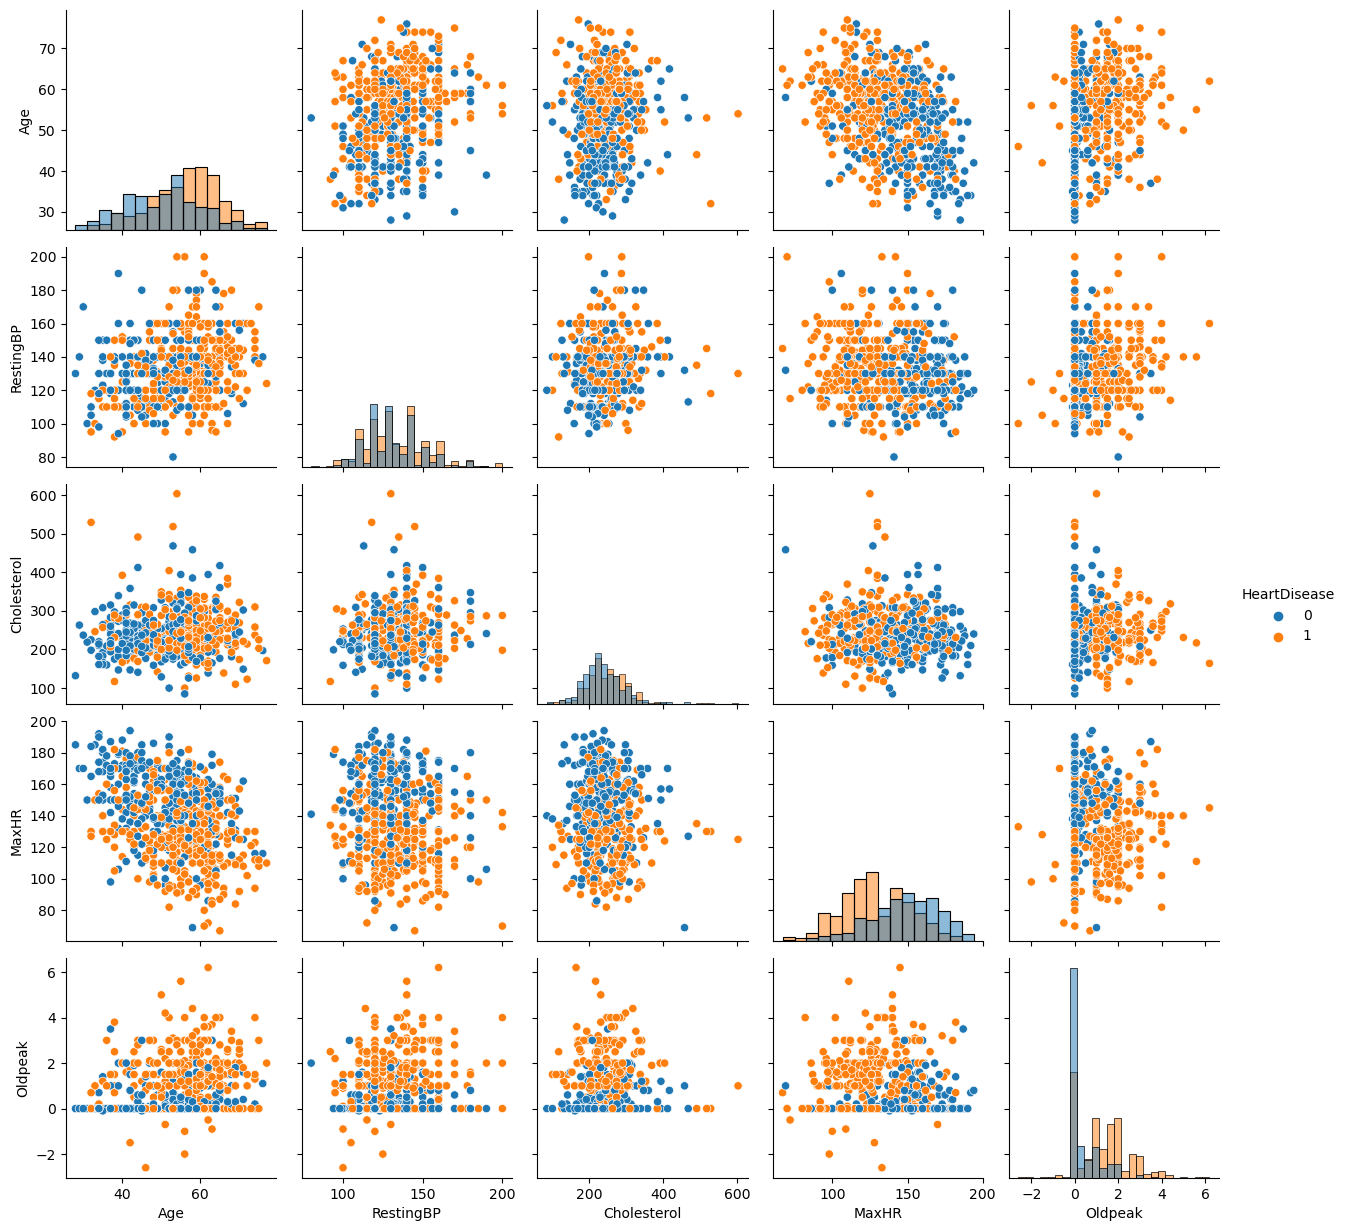

In [5]:
sns.pairplot(data=df1[['HeartDisease', 'Age','RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']], diag_kind="hist", hue='HeartDisease')
plt.show()

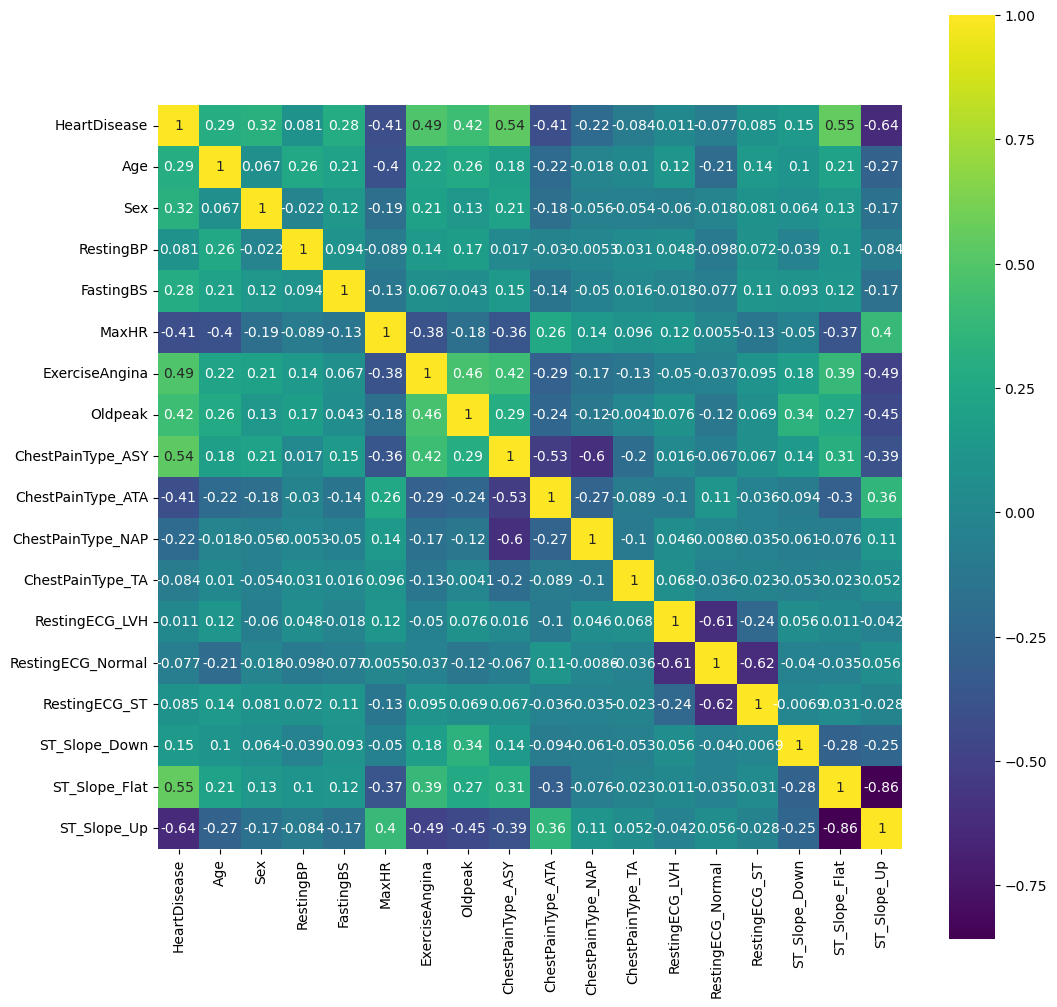

In [6]:
cm = np.corrcoef(df1.drop(columns=['Cholesterol']).dropna(how='any').values.T)

plt.figure(figsize = (12, 12))
heat_map = sns.heatmap(cm, xticklabels=df1.drop(columns=['Cholesterol']).columns, yticklabels=df1.drop(columns=['Cholesterol']).columns, cmap='viridis', annot=True, square=True)

In [7]:
display(df1.describe())

,HeartDisease,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
count,642.000000,642.000000,642.000000,642.000000,519.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000
mean,0.559190,53.556075,0.786604,132.101246,243.414258,0.247664,137.395639,0.389408,0.876791,0.545171,0.190031,0.232087,0.032710,0.188474,0.618380,0.193146,0.076324,0.492212,0.431464
std,0.496871,9.542620,0.410024,18.006691,59.626572,0.431992,24.624338,0.487996,1.084168,0.498344,0.392631,0.422494,0.178016,0.391395,0.486163,0.395075,0.265723,0.500329,0.495667
min,0.000000,28.000000,0.000000,80.000000,85.000000,0.000000,67.000000,0.000000,-2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,47.000000,1.000000,120.000000,208.000000,0.000000,120.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,54.000000,1.000000,130.000000,235.000000,0.000000,139.000000,0.000000,0.500000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,61.000000,1.000000,140.000000,274.000000,0.000000,156.000000,1.000000,1.500000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,77.000000,1.000000,200.000000,603.000000,1.000000,194.000000,1.000000,6.200000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 説明変数について考える①

[1](https://med.toaeiyo.co.jp/contents/ecg/pdf/ecg2-2.pdf), 
[2(p.17)](https://www.j-circ.or.jp/cms/wp-content/uploads/2020/02/JCS2018_yamagishi_tamaki.pdf), 
[3](https://www.miyake-naika.or.jp/05_health/shindenzu/shindenzu_04.html#5), 
[4](https://www.revespcardiol.org/en-typical-angina-atypical-angina-atypical-articulo-S1885585720304692)

## 狭心症の種類について
- 労作性狭心症
    - 運動時には、心筋の酸素需要が上昇するも、冠状動脈の狭窄により酸素供給が追いつかず、心筋虚血により胸痛をもたらす
    - 運動時にはSTが低下する → Oldpeakが正の値
    - 安静時には異常は見られない → RestingECG_STは0
    - 運動時のST低下には、右下がり、水平、右上がりがある → 低下していることが重要なので、この3つの区別には意味がない?ST_Slope_Down, ST_Slope_Flat, ST_Slope_Upのこと?
- 安静狭心症
    - 冠状動脈のけいれんによる心筋虚血により胸痛をもたらす
    - 心内膜側だけが虚血しているとST低下、心外膜側まで虚血しているとST上昇 → STでは見分けられない?

## 考察①
- 最も目的変数と相関しているのが、胸痛の種類の中でChestPainType_ASYな時点で、かなり特殊な病態を目的変数なのでは? 痛みを伴わない病態が目的変数と考えてよさそう。<br>
- ExerciseAnginaも目的変数と相関している。これは、ChestPainType_ASYが目的変数と相関していることと矛盾する。<br>
- ひとまずExerciseAnginaとChestPainType_ASYで散布図を描いて確認してみる: <br>

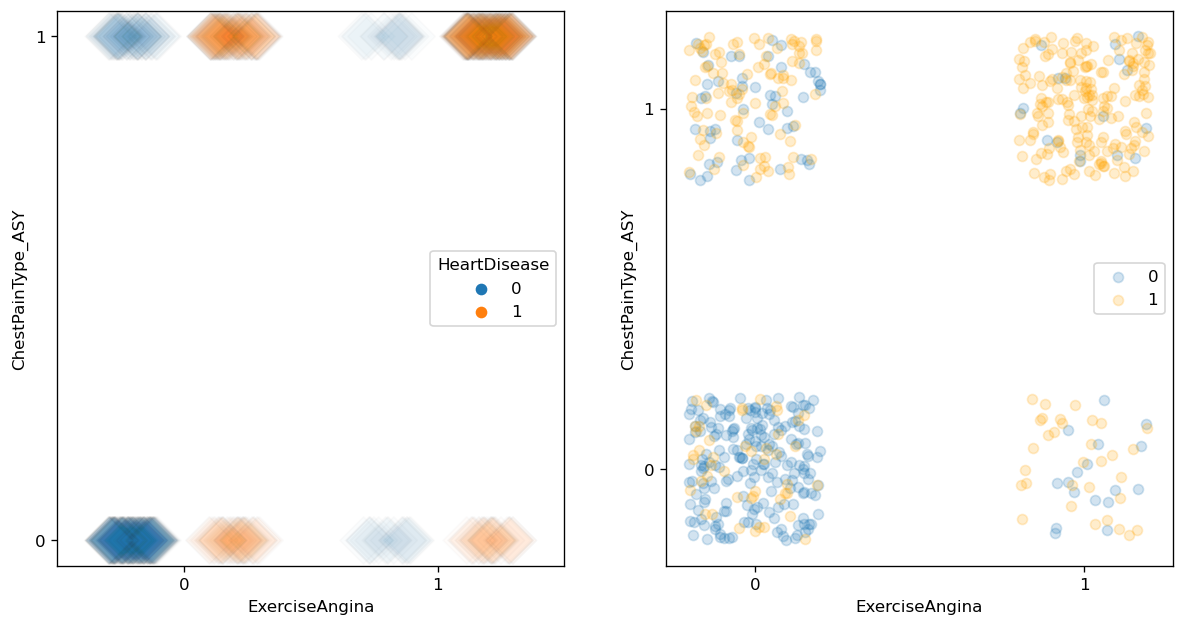

In [8]:
fig = plt.figure(figsize=(12, 6), dpi=120)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
sns.stripplot(data=df1, x='ExerciseAngina', y='ChestPainType_ASY', hue='HeartDisease', alpha=0.02, jitter=0.2, dodge=True, s=20, marker="D", linewidth=1, ax=ax1).set(xticks=range(0,2), yticks=range(0, 2))
sns.regplot(data=df1[df1['HeartDisease'] == 0], x='ExerciseAngina', y='ChestPainType_ASY', x_jitter=.2, y_jitter=.2, scatter_kws={'alpha':0.2}, fit_reg=False, label='0', ax=ax2).set(xticks=range(0,2), yticks=range(0, 2))
sns.regplot(data=df1[df1['HeartDisease'] == 1], x='ExerciseAngina', y='ChestPainType_ASY', x_jitter=.2, y_jitter=.2, scatter_kws={'alpha':0.2}, fit_reg=False, label='1', color='orange', ax=ax2).legend()
plt.show()

- やはり、ExerciseAnginaが1かつChestPainType_ASYが1の人に陽性が多い。運動誘発性の狭心症があるけど痛みは無症状の人?<br>
- 筋痛が無症状の人がターゲットになっているから、ターゲットは心筋梗塞ではなさそう（心筋梗塞で痛くないということはないらしいので）<br>

## 考察②
- Oldpeakの結果をみるに、運動時にST低下するような病気が今回ターゲットになっている<br>
- ST上昇はやばい病気であることが確実（心筋梗塞か狭心症しかありえないらしい）<br>
- ST低下はやばい病気を含むけれどさらなる弁別が必要（心筋梗塞や狭心症以外にもありうるので）<br>
- 運動時にSTが低下していても、ST_Slopeが右上がりなら正常といえる（心拍数増加時や貧血、電解質異常や心臓神経の過敏があるときにもみられる波形）<br>
- たしかに以下の相関行列でも、ST_Slope_UPはMaxHRと正の相関が見られるし、その他の病的な症候とST_Slope_UPは負の相関になっている: <br>

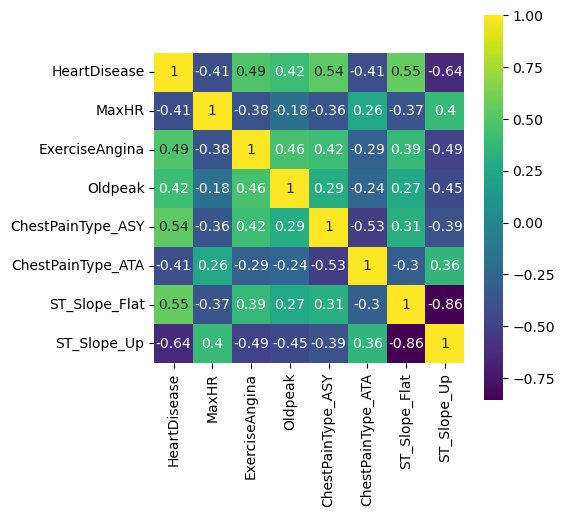

In [9]:
cols2 = ['HeartDisease', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ST_Slope_Flat', 'ST_Slope_Up']
cm2 = np.corrcoef(df1[cols2].dropna(how='any').values.T)
plt.figure(figsize = (5, 5))
heat_map = sns.heatmap(cm2, xticklabels=cols2, yticklabels=cols2, cmap='viridis', annot=True, square=True)

- ST_slopeは、以下に見るように、Flatの人に病気の該当者が多い: <br>

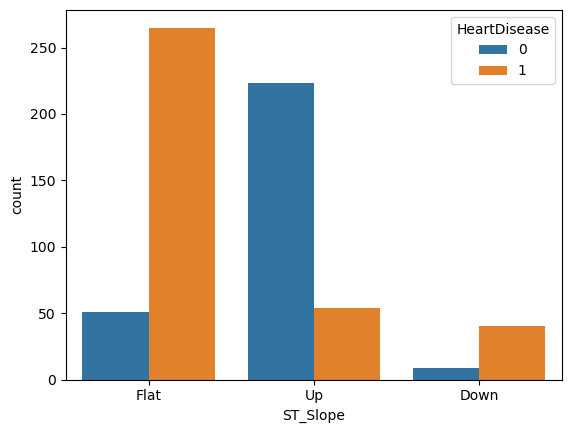

In [10]:
sns.countplot(data=df0.iloc[:, [-1, 10]], x=df0.columns[10], hue='HeartDisease')
plt.show()

## 考察③
- 考察①・②より、運動誘発性狭心症ありかつ運動時ST低下がターゲットなので、おそらくは心内膜側の心筋虚血か労作性狭心症をターゲットにしていると考えてよいだろう<br>
- あるいは(といっても上とは矛盾しないが)、無症候性冠動脈疾患かも…運動すると心電図等では心筋虚血の兆候が現れるのに本人は自覚症状がないパターン。糖尿病や高齢者に多い疾患。
- 運動誘発性狭心症(ExerciseAngina)と運動時ST低下(Oldpeak)の散布図を見てみよう: 

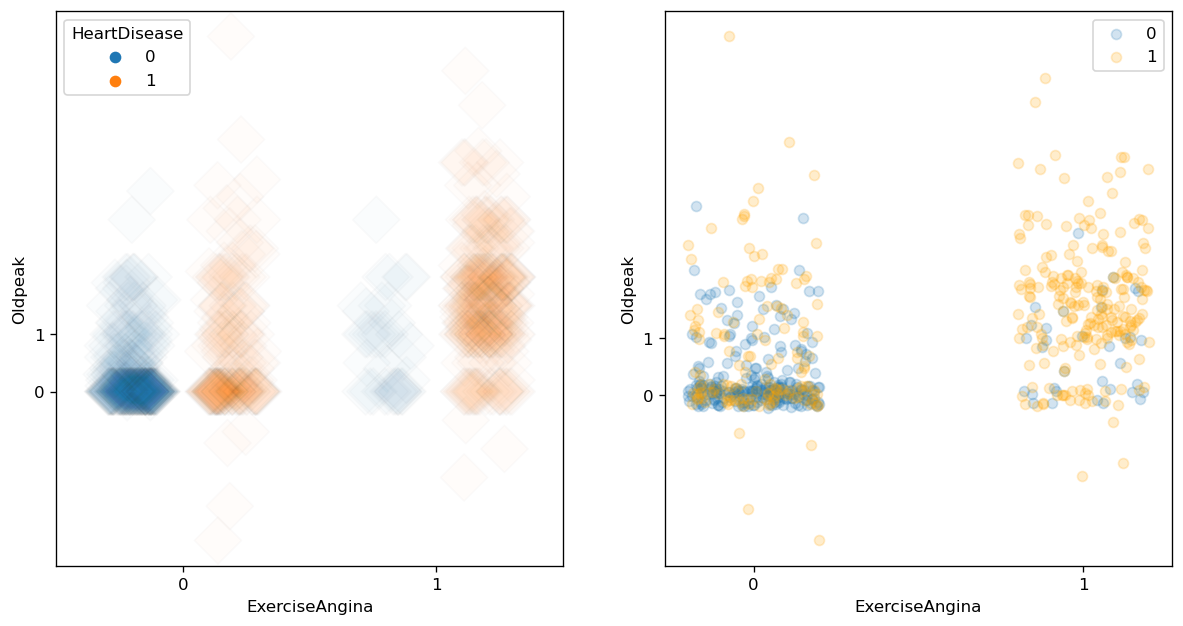

In [11]:
fig = plt.figure(figsize=(12, 6), dpi=120)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
sns.stripplot(data=df1, y='Oldpeak', x='ExerciseAngina', hue='HeartDisease', alpha=0.02, jitter=0.2, dodge=True, s=20, marker="D", linewidth=1, ax=ax1).set(xticks=range(0,2), yticks=range(0, 2))
sns.regplot(data=df1[df1['HeartDisease'] == 0], y='Oldpeak', x='ExerciseAngina', x_jitter=.2, y_jitter=.2, scatter_kws={'alpha':0.2}, fit_reg=False, label='0', ax=ax2).set(xticks=range(0,2), yticks=range(0, 2))
sns.regplot(data=df1[df1['HeartDisease'] == 1], y='Oldpeak', x='ExerciseAngina', x_jitter=.2, y_jitter=.2, scatter_kws={'alpha':0.2}, fit_reg=False, label='1', color='orange', ax=ax2).legend()
plt.show()

- ほのかな相関が見られるが、他に条件を追加しないと弁別できないこともわかる

## 考察④
- コレステロールや血糖値は病気クラスと非病気クラスで大差ないので、ひとまず置いておいて良いかも（他で区別つかなかったときの最終兵器にはなるかも）
- そもそも母集団が、「なんらかの心臓病かなにかを抱えた人たち」と考えるべき

## 考察⑤
- 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ST_Slope_Flat', 'ST_Slope_Up'だけで決定木してみる: 

In [12]:
cols_used, X_train, y_train, _, X_test, y_test, *_ = prepro(cols2)

tree_model = DecisionTreeClassifier(criterion='entropy', random_state=1)
param1 = np.arange(1, 11)
param2 = np.arange(2, 31)
param3 = np.arange(1, 21)
param_grid = [{'max_depth': param1, 
               'max_leaf_nodes': param2,
               'min_samples_split': param3}]

# GridsearchCVクラスをインスタンス化: gsインスタンスを作成
gs = GridSearchCV(estimator=tree_model,
                  param_grid=param_grid, # ハイパーパラメータの候補を渡す
                  scoring='accuracy', # 正解率で競わせる
                  return_train_score=True,
                  cv=3, # 3分割で交差検証する
                  n_jobs=-1) # CPUをフルに使う
gs = gs.fit(X_train, y_train)
print('グリッドサーチのテスト用サブセットでの最良スコア:', gs.best_score_, '\nその時のパラメータ:', gs.best_params_)

X_train.shape: (513, 7)
X_test.shape: (129, 7)
グリッドサーチのテスト用サブセットでの最良スコア: 0.847953216374269 
その時のパラメータ: {'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_split': 1}


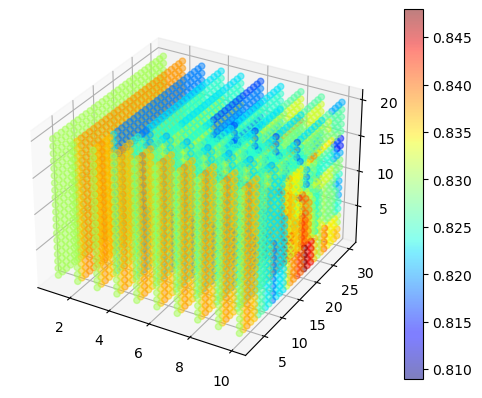

In [13]:
# %matplotlib tk
cv_result = pd.DataFrame(gs.cv_results_)[['mean_test_score', 'param_max_depth', 'param_max_leaf_nodes', 'param_min_samples_split']]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', aspect='auto')
sc = ax.scatter(cv_result['param_max_depth'], cv_result['param_max_leaf_nodes'], cv_result['param_min_samples_split'], c=cv_result['mean_test_score'], alpha=0.5, cmap='jet')
fig.colorbar(sc)
plt.show()

In [14]:
%matplotlib inline

学習用データでの正解率: 0.8869395711500975
テスト用データでの正解率: 0.7984496124031008


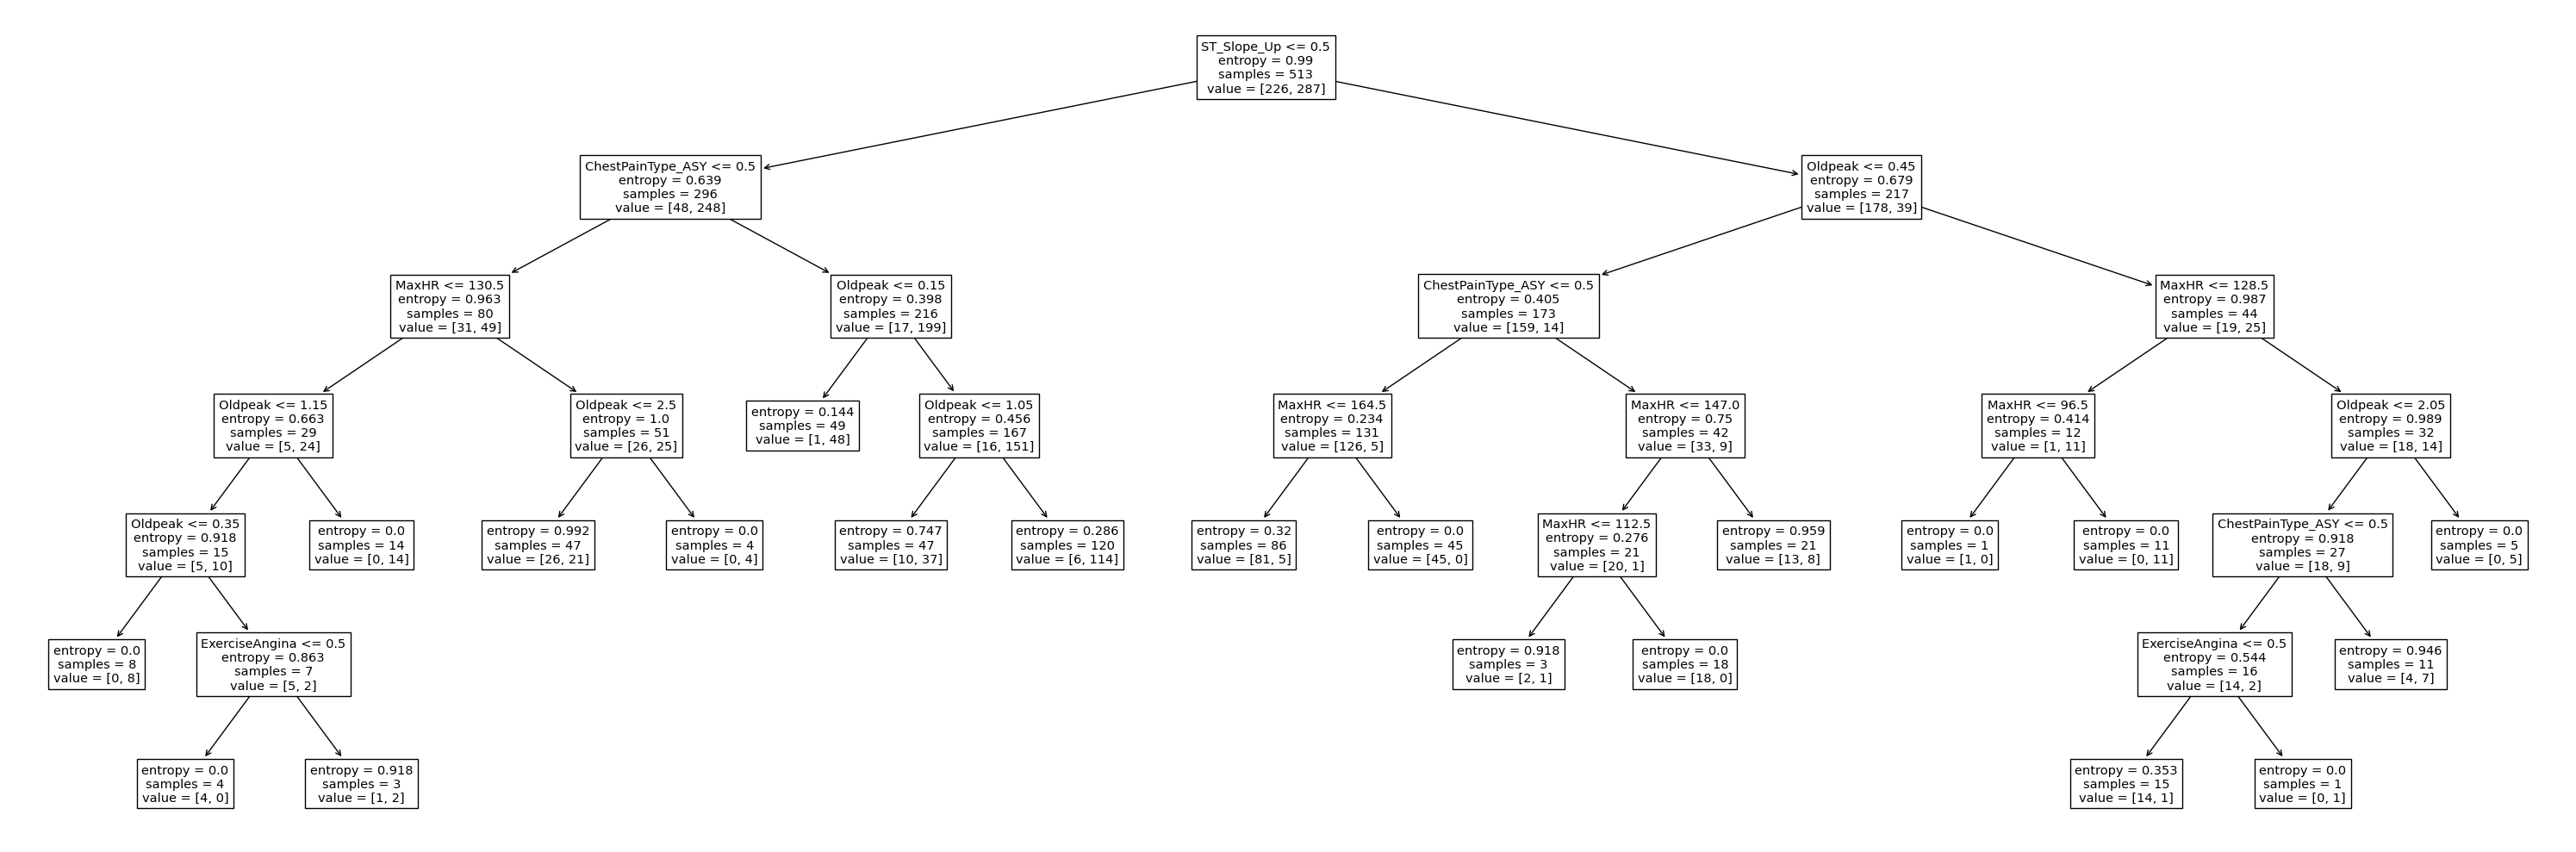

 1) ST_Slope_Up                    0.541637
 2) Oldpeak                        0.214327
 3) ChestPainType_ASY              0.126882
 4) MaxHR                          0.095988
 5) ExerciseAngina                 0.021166
 6) ST_Slope_Flat                  0.000000
 7) ChestPainType_ATA              0.000000


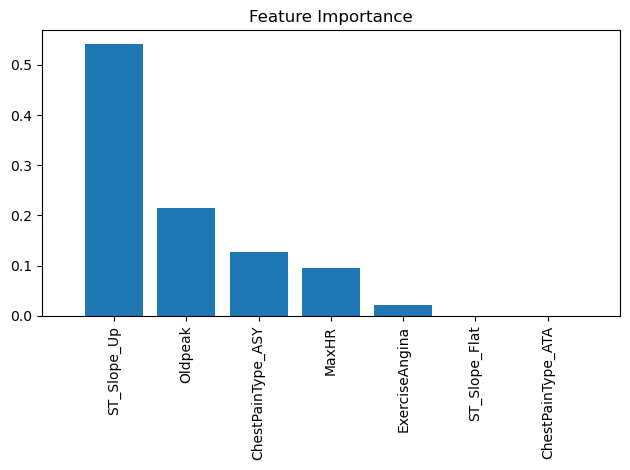

In [15]:
tree_model = DecisionTreeClassifier(criterion='entropy', 
                                    max_depth=gs.best_params_['max_depth'],
                                    max_leaf_nodes=gs.best_params_['max_leaf_nodes'],
                                    min_samples_split=gs.best_params_['min_samples_split'],
                                    random_state=1)

tree_model.fit(X_train, y_train)

print('学習用データでの正解率:', (tree_model.predict(X_train) == y_train).mean())
print('テスト用データでの正解率:', (tree_model.predict(X_test) == y_test).mean())

plt.figure(figsize=(30, 10))
tree.plot_tree(tree_model, feature_names=cols_used, fontsize=10.5)
plt.tight_layout()
plt.show()

importances = tree_model.feature_importances_
indices = np.argsort(importances)[::-1]


for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            cols_used[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')
plt.xticks(range(X_train.shape[1]), 
           cols_used[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

# 説明変数を取捨選択する

## 特徴量選択

### L1正則化したロジスティック回帰
[# ロジスティック回帰(限界がある)](#ロジスティック回帰(限界がある))

### 決定木

In [16]:
cols_used, X_train, y_train, _, X_test, y_test, *_ = prepro()

tree_model = DecisionTreeClassifier(criterion='entropy', random_state=1)
param1 = np.arange(1, 11)
param2 = np.arange(2, 31)
param3 = np.arange(1, 21)
param_grid = [{'max_depth': param1, 
               'max_leaf_nodes': param2,
               'min_samples_split': param3}]

# GridsearchCVクラスをインスタンス化: gsインスタンスを作成
gs = GridSearchCV(estimator=tree_model,
                  param_grid=param_grid, # ハイパーパラメータの候補を渡す
                  scoring='accuracy', # 正解率で競わせる
                  return_train_score=True,
                  cv=2, # 5分割で交差検証する
                  n_jobs=-1) # CPUをフルに使う
gs = gs.fit(X_train, y_train)
print('グリッドサーチのテスト用サブセットでの最良スコア:', gs.best_score_, '\nその時のパラメータ:', gs.best_params_)

X_train.shape: (513, 17)
X_test.shape: (129, 17)
グリッドサーチのテスト用サブセットでの最良スコア: 0.8499057636186771 
その時のパラメータ: {'max_depth': 3, 'max_leaf_nodes': 7, 'min_samples_split': 1}


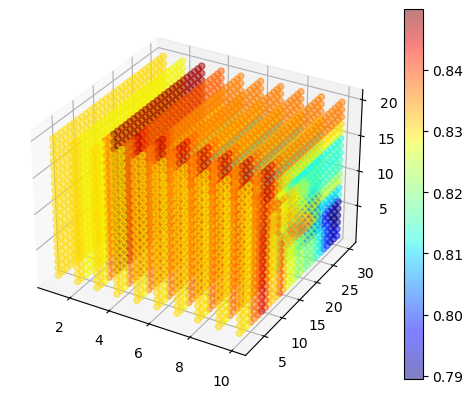

In [17]:
# %matplotlib tk
cv_result = pd.DataFrame(gs.cv_results_)[['mean_test_score', 'param_max_depth', 'param_max_leaf_nodes', 'param_min_samples_split']]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', aspect='auto')
sc = ax.scatter(cv_result['param_max_depth'], cv_result['param_max_leaf_nodes'], cv_result['param_min_samples_split'], c=cv_result['mean_test_score'], alpha=0.5, cmap='jet')
fig.colorbar(sc)
plt.show()

In [18]:
%matplotlib inline

学習用データでの正解率: 0.8596491228070176
テスト用データでの正解率: 0.8217054263565892


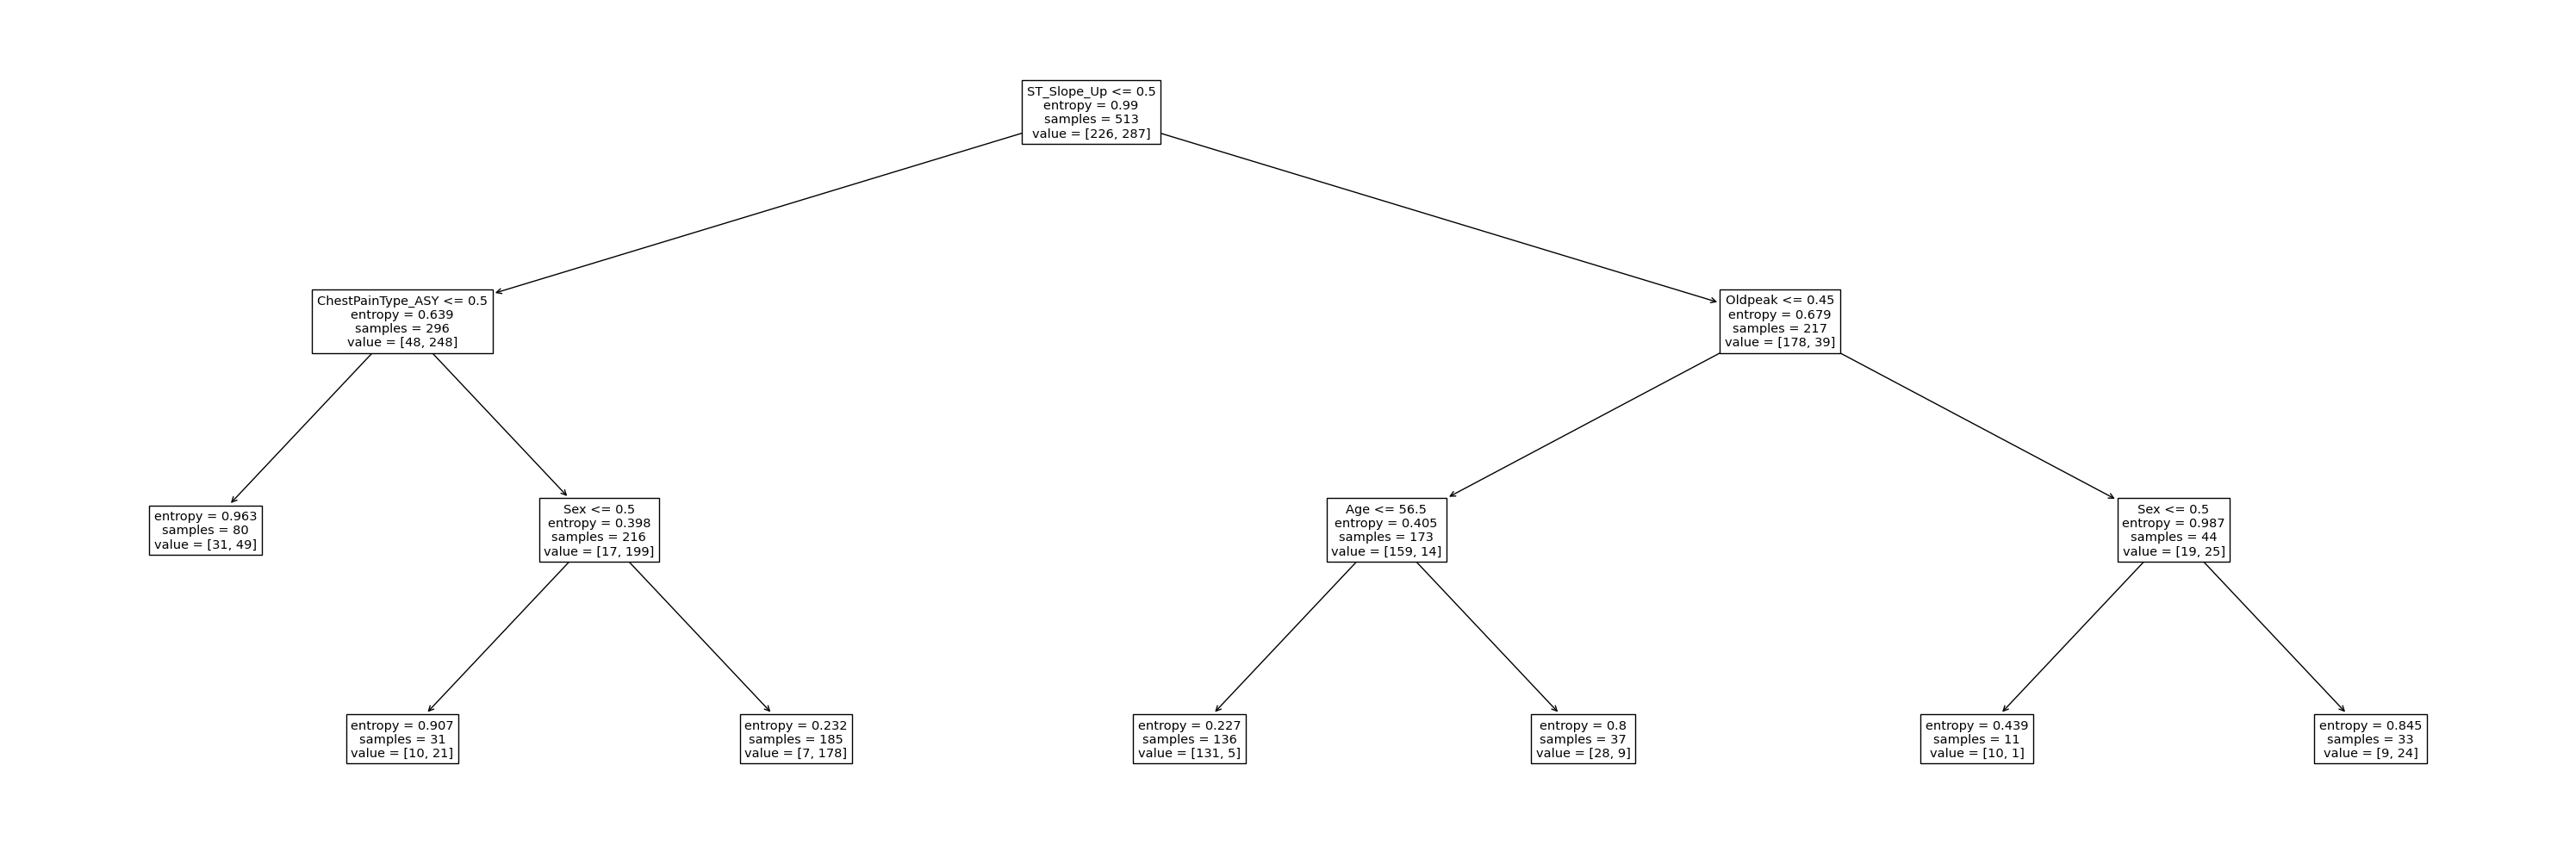

<class 'numpy.ndarray'>
 1) ST_Slope_Up                    0.642118
 2) Oldpeak                        0.127267
 3) ChestPainType_ASY              0.098911
 4) Sex                            0.095594
 5) Age                            0.036110
 6) RestingECG_LVH                 0.000000
 7) ChestPainType_TA               0.000000
 8) ChestPainType_NAP              0.000000
 9) ST_Slope_Flat                  0.000000
10) RestingECG_Normal              0.000000
11) RestingECG_ST                  0.000000
12) ExerciseAngina                 0.000000
13) MaxHR                          0.000000
14) FastingBS                      0.000000
15) RestingBP                      0.000000
16) ST_Slope_Down                  0.000000
17) ChestPainType_ATA              0.000000


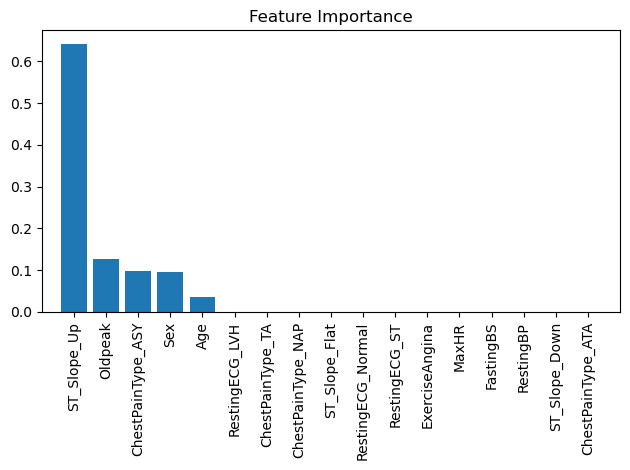

In [19]:
tree_model = DecisionTreeClassifier(criterion='entropy', 
                                    max_depth=gs.best_params_['max_depth'],
                                    max_leaf_nodes=gs.best_params_['max_leaf_nodes'],
                                    min_samples_split=gs.best_params_['min_samples_split'],
                                    random_state=1)
tree_model.fit(X_train, y_train)

print('学習用データでの正解率:', (tree_model.predict(X_train) == y_train).mean())
print('テスト用データでの正解率:', (tree_model.predict(X_test) == y_test).mean())

plt.figure(figsize=(30, 10))
tree.plot_tree(tree_model, feature_names=cols_used, fontsize=10.5)
plt.tight_layout()
plt.show()

importances = tree_model.feature_importances_
indices = np.argsort(importances)[::-1]
print(type(indices))

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            cols_used[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')
plt.xticks(range(X_train.shape[1]), 
           cols_used[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

### ランダムフォレスト

X_train.shape: (513, 17)
X_test.shape: (129, 17)
oob 0.8713450292397661
学習用データでの正解率: 0.9083820662768031
テスト用データでの正解率: 0.8294573643410853
 1) ST_Slope_Up                    0.235403
 2) ST_Slope_Flat                  0.161081
 3) ChestPainType_ASY              0.130154
 4) Oldpeak                        0.121841
 5) MaxHR                          0.064658
 6) ExerciseAngina                 0.058200
 7) Age                            0.054943
 8) Sex                            0.041297
 9) ChestPainType_ATA              0.035488
10) RestingBP                      0.029545
11) FastingBS                      0.025528
12) ST_Slope_Down                  0.010048
13) ChestPainType_NAP              0.009241
14) RestingECG_LVH                 0.008034
15) ChestPainType_TA               0.006671
16) RestingECG_Normal              0.005268
17) RestingECG_ST                  0.002600


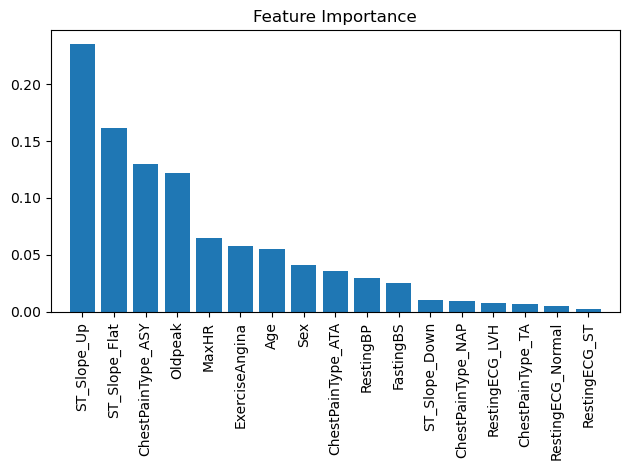

In [20]:
cols_used, X_train, y_train, _, X_test, y_test, *_ = prepro()

forest = RandomForestClassifier(n_estimators=1000,
                                max_leaf_nodes=16,
                                max_features='sqrt',
                                oob_score=True,
                                random_state=1)

forest.fit(X_train, y_train)

print('oob', forest.oob_score_)
print('学習用データでの正解率:', (forest.predict(X_train) == y_train).mean())
print('テスト用データでの正解率:', (forest.predict(X_test) == y_test).mean())

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            cols_used[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           cols_used[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

## 特徴量抽出

### LDA

In [21]:
cols_used, _, y_train, X_train_ss, _, y_test, X_test_ss = prepro()
lda = LDA(n_components=1) # 目的変数のクラス数が2しかないため、圧縮後の次元数は1次元しか選べない

# 圧縮後の説明変数でロジスティック回帰してみる
X_train_lda = lda.fit_transform(X_train_ss, y_train)
lr = LogisticRegression(multi_class='auto', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)

print('学習用データでの正解率:', (lr.predict(lda.transform(X_train_ss)) == y_train).mean())
print('テスト用データでの正解率:', (lr.predict(lda.transform(X_test_ss)) == y_test).mean())

X_train.shape: (513, 17)
X_test.shape: (129, 17)
学習用データでの正解率: 0.8752436647173489
テスト用データでの正解率: 0.8372093023255814


# 予測

## ロジスティック回帰(限界がある)

solverとpenaltyの使用可能な組み合わせ
- 'lbfgs'           -   ['l2', None]
- 'liblinear'       -   ['l1', 'l2']
- 'newton-cg'       -   ['l2', None]
- 'newton-cholesky' -   ['l2', None]
- 'sag'             -   ['l2', None]
- 'saga'            -   ['elasticnet', 'l1', 'l2', None]

In [22]:
# ロジスティック回帰
cols_used, _, y_train, X_train_ss, _, y_test, X_test_ss = prepro()

logi = LogisticRegression(C=1, solver='lbfgs', penalty='l2')
# logi = LogisticRegression(C=0.08, solver='liblinear', penalty='l1')
logi.fit(X_train_ss, y_train)

print('学習用データでの正解率:', (logi.predict(X_train_ss) == y_train).mean())
print('テスト用データでの正解率:', (logi.predict(X_test_ss) == y_test).mean())
print('切片:', logi.intercept_)
display(pd.DataFrame({'変数名': cols_used, '係数': logi.coef_[0]}))
cols_lasso = cols_used[np.where(logi.coef_[0] != 0)]

X_train.shape: (513, 17)
X_test.shape: (129, 17)
学習用データでの正解率: 0.8791423001949318
テスト用データでの正解率: 0.8449612403100775
切片: [0.38324779]


,変数名,係数
0,Age,0.269259
1,Sex,0.714721
2,RestingBP,-0.008702
3,FastingBS,0.617964
4,MaxHR,-0.106547
5,ExerciseAngina,0.148989
6,Oldpeak,0.632218
7,ChestPainType_ASY,0.513717
8,ChestPainType_ATA,-0.355684
9,ChestPainType_NAP,-0.229666


## SVM

X_train.shape: (513, 17)
X_test.shape: (129, 17)
グリッドサーチのテスト用サブセットでの最良スコア: 0.863539640077821 
その時のパラメータ: {'C': 100.0, 'gamma': 1e-05, 'kernel': 'rbf'}
学習用データでの正解率: 0.8654970760233918
テスト用データでの正解率: 0.8294573643410853


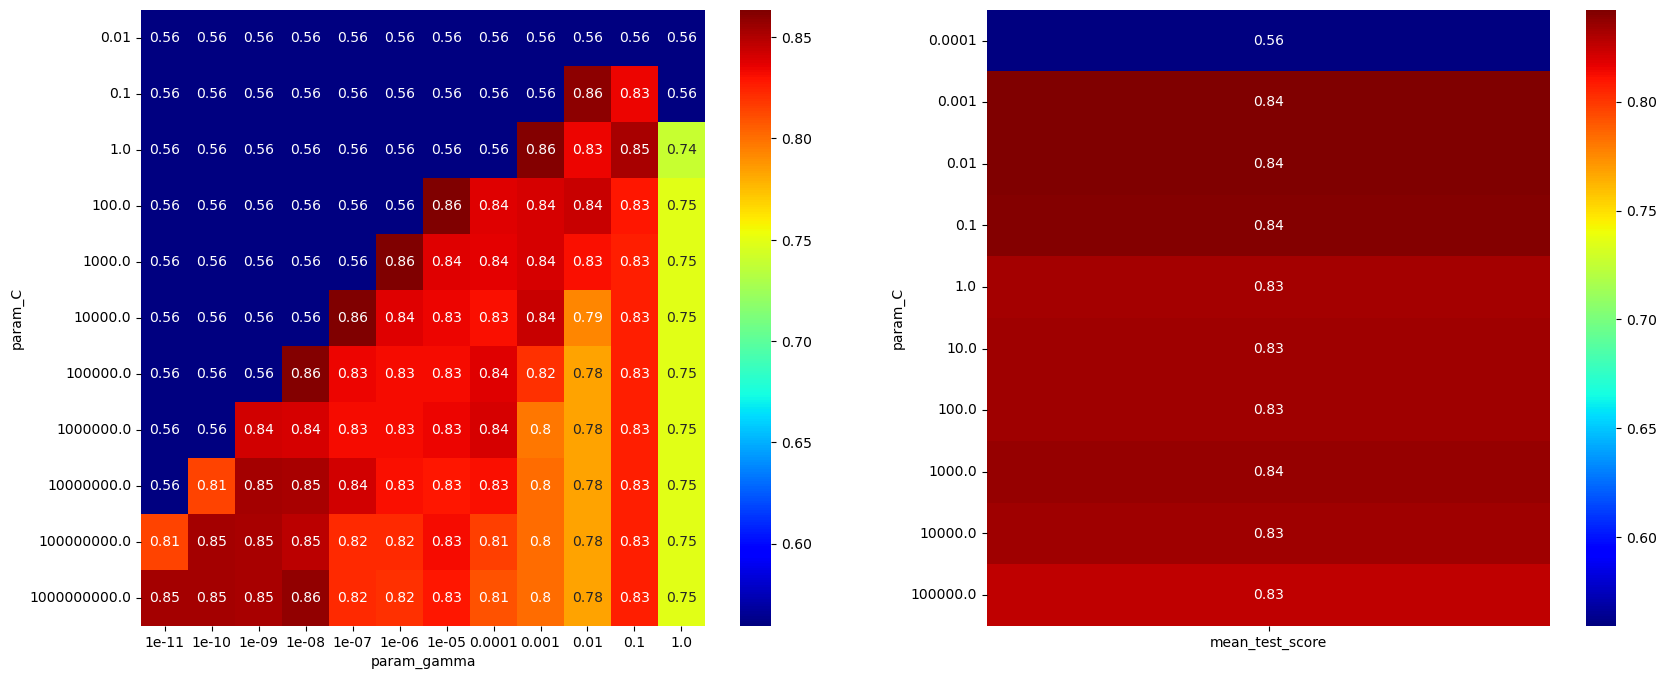

In [23]:
cols_used, _, y_train, X_train_ss, _, y_test, X_test_ss = prepro()

svm = SVC(random_state=1)
param_C_linear = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]
param_C_rbf = [1e-2, 1e-1, 1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9]
param_gamma_rbf = [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
param_grid = [{'C': param_C_linear, 
               'kernel': ['linear']},
              {'C': param_C_rbf, 
               'gamma': param_gamma_rbf, 
               'kernel': ['rbf']}]

# GridsearchCVクラスをインスタンス化: gsインスタンスを作成
gs = GridSearchCV(estimator=svm,
                  param_grid=param_grid, # ハイパーパラメータの候補を渡す
                  scoring='accuracy', # 正解率で競わせる
                  cv=2, # 2分割で交差検証する
                  n_jobs=-1)
gs = gs.fit(X_train_ss, y_train)
print('グリッドサーチのテスト用サブセットでの最良スコア:', gs.best_score_, '\nその時のパラメータ:', gs.best_params_)

# %matplotlib tk
cv_result = pd.DataFrame(gs.cv_results_)[['mean_test_score', 'param_kernel', 'param_C', 'param_gamma']]
cv_result_rbf = cv_result[cv_result['param_kernel'] == 'rbf'].drop(columns='param_kernel')
cv_result_linear = cv_result[cv_result['param_kernel'] == 'linear'].drop(columns='param_kernel')

cv_result_pivot_rbf = cv_result_rbf.pivot_table('mean_test_score', 'param_C', 'param_gamma')
cv_result_pivot_linear = cv_result_linear.pivot_table('mean_test_score', 'param_C')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8)) # プロットエリアを準備する
# 左: RBFカーネルでの、パラメータ（２つ）による正解率の違い
heat_map = sns.heatmap(cv_result_pivot_rbf, cmap='jet', annot=True, ax=ax1)
# 右: 線形カーネルでの、パラメータ（１つ）による正解率の違い
heat_map = sns.heatmap(cv_result_pivot_linear, cmap='jet', annot=True, ax=ax2)

svm = SVC(kernel=gs.best_params_['kernel'], C=gs.best_params_['C'], gamma=gs.best_params_.get('gamma', 'scale'), random_state=1)
svm.fit(X_train_ss, y_train)
print('学習用データでの正解率:', (svm.predict(X_train_ss) == y_train).mean())
print('テスト用データでの正解率:', (svm.predict(X_test_ss) == y_test).mean())

### 説明変数を7つにしぼってSVM

X_train.shape: (513, 4)
X_test.shape: (129, 4)
グリッドサーチのテスト用サブセットでの最良スコア: 0.756338156614786 
その時のパラメータ: {'C': 1000000.0, 'gamma': 1e-07, 'kernel': 'rbf'}
学習用データでの正解率: 0.7543859649122807
テスト用データでの正解率: 0.6821705426356589


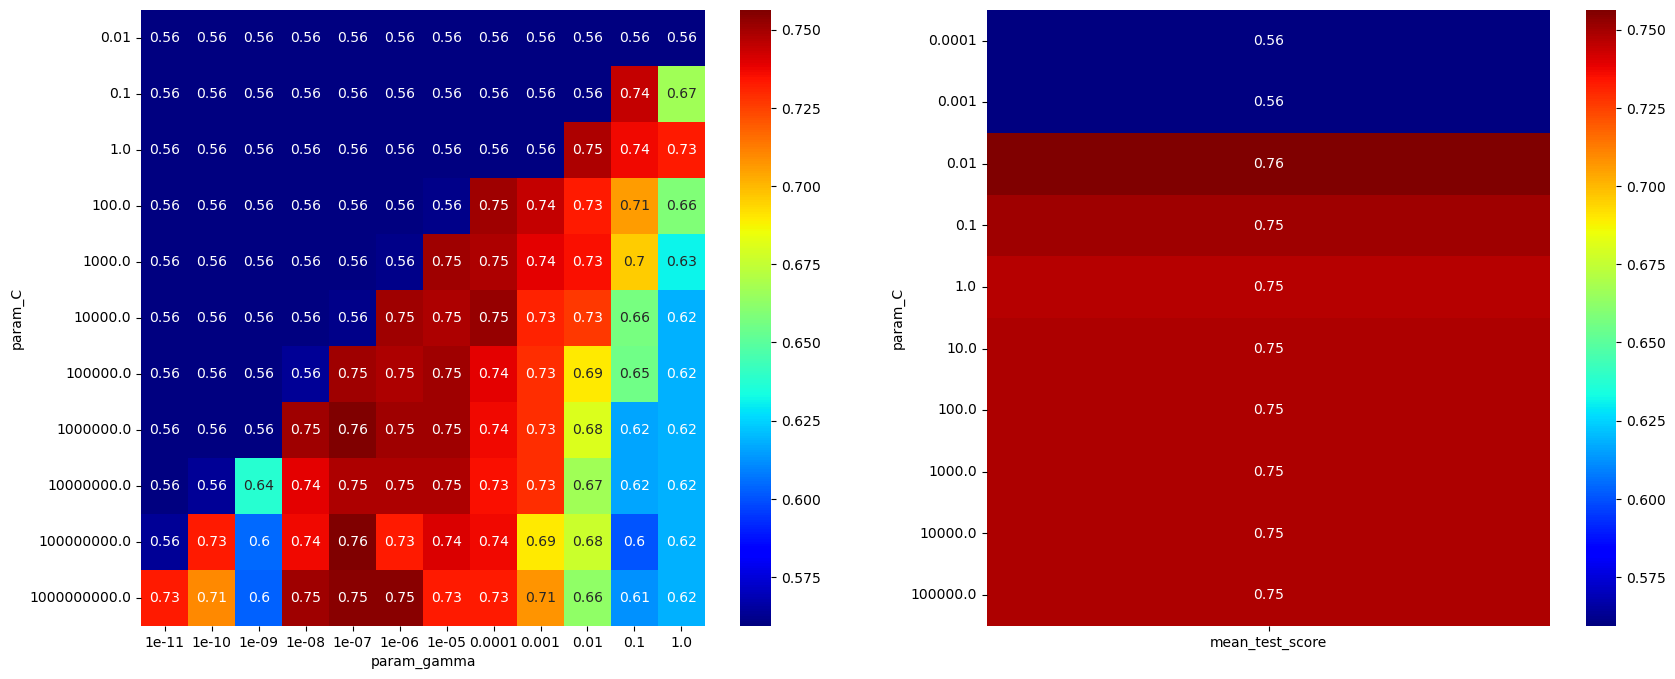

In [24]:
cols_used, _, y_train, X_train_ss, _, y_test, X_test_ss = prepro(cols=['HeartDisease', 'Age','RestingBP', 'MaxHR', 'Oldpeak'])

svm = SVC(random_state=1)
param_C_linear = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]
param_C_rbf = [1e-2, 1e-1, 1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9]
param_gamma_rbf = [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
param_grid = [{'C': param_C_linear, 
               'kernel': ['linear']},
              {'C': param_C_rbf, 
               'gamma': param_gamma_rbf, 
               'kernel': ['rbf']}]

# GridsearchCVクラスをインスタンス化: gsインスタンスを作成
gs = GridSearchCV(estimator=svm,
                  param_grid=param_grid, # ハイパーパラメータの候補を渡す
                  scoring='accuracy', # 正解率で競わせる
                  return_train_score=True,
                  cv=2, # 2分割で交差検証する
                  n_jobs=-1)
gs = gs.fit(X_train_ss, y_train)
print('グリッドサーチのテスト用サブセットでの最良スコア:', gs.best_score_, '\nその時のパラメータ:', gs.best_params_)

# %matplotlib tk
cv_result = pd.DataFrame(gs.cv_results_)[['mean_test_score', 'param_kernel', 'param_C', 'param_gamma']]
cv_result_rbf = cv_result[cv_result['param_kernel'] == 'rbf']
cv_result_linear = cv_result[cv_result['param_kernel'] == 'linear']

cv_result_pivot_rbf = cv_result_rbf.pivot_table('mean_test_score', 'param_C', 'param_gamma')
cv_result_pivot_linear = cv_result_linear.pivot_table('mean_test_score', 'param_C')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8)) # プロットエリアを準備する
# 左: RBFカーネルでの、パラメータ（２つ）による正解率の違い
heat_map = sns.heatmap(cv_result_pivot_rbf, cmap='jet', annot=True, ax=ax1)
# 右: 線形カーネルでの、パラメータ（１つ）による正解率の違い
heat_map = sns.heatmap(cv_result_pivot_linear, cmap='jet', annot=True, ax=ax2)

svm = SVC(kernel=gs.best_params_['kernel'], C=gs.best_params_['C'], gamma=gs.best_params_.get('gamma', 'scale'), random_state=1)
svm.fit(X_train_ss, y_train)
print('学習用データでの正解率:', (svm.predict(X_train_ss) == y_train).mean())
print('テスト用データでの正解率:', (svm.predict(X_test_ss) == y_test).mean())

# 説明変数について考える②

真陽性、偽陰性、偽陽性、真陽性のひとたちでgroupbyして、特徴量の差をみるべき<br>

In [25]:
# 非カテゴリ変数でSVM

# cols_used, _, y_train, X_train_ss, _, y_test, X_test_ss = prepro(cols=['HeartDisease', 'Age','RestingBP', 'MaxHR', 'Oldpeak'])
cols_used, _, y_train, X_train_ss, _, y_test, X_test_ss = prepro()
# d = {'C': 10000000.0, 'gamma': 1e-07, 'kernel': 'rbf'}
d = {'C': 100.0, 'gamma': 1e-05, 'kernel': 'rbf'}
svm = SVC(kernel=d['kernel'], C=d['C'], gamma=d.get('gamma', 'scale'), probability=True, random_state=1)

svm.fit(X_train_ss, y_train)
print('学習用データでの正解率:', (svm.predict(X_train_ss) == y_train).mean())
print('テスト用データでの正解率:', (svm.predict(X_test_ss) == y_test).mean())
cols_used, X_train, y_train, *_ = prepro(drop_Cholesterol=False, drop_na=False)
df = pd.DataFrame(X_train, columns=cols_used)

df['predict_svm'] = svm.predict(X_train_ss)
df['predict_proba_svm'] = svm.predict_proba(X_train_ss)[:, 1]


X_train.shape: (513, 17)
X_test.shape: (129, 17)
学習用データでの正解率: 0.8654970760233918
テスト用データでの正解率: 0.8294573643410853
Cholesterol列もNaNを含む行も残っています。
X_train.shape: (513, 18)
X_test.shape: (129, 18)


X_train.shape: (513, 13)
X_test.shape: (129, 13)
グリッドサーチのテスト用サブセットでの最良スコア: 0.8538348127431907 
その時のパラメータ: {'max_depth': 7, 'max_leaf_nodes': 27, 'min_samples_split': 5}
学習用データでの正解率: 0.8947368421052632
テスト用データでの正解率: 0.8372093023255814


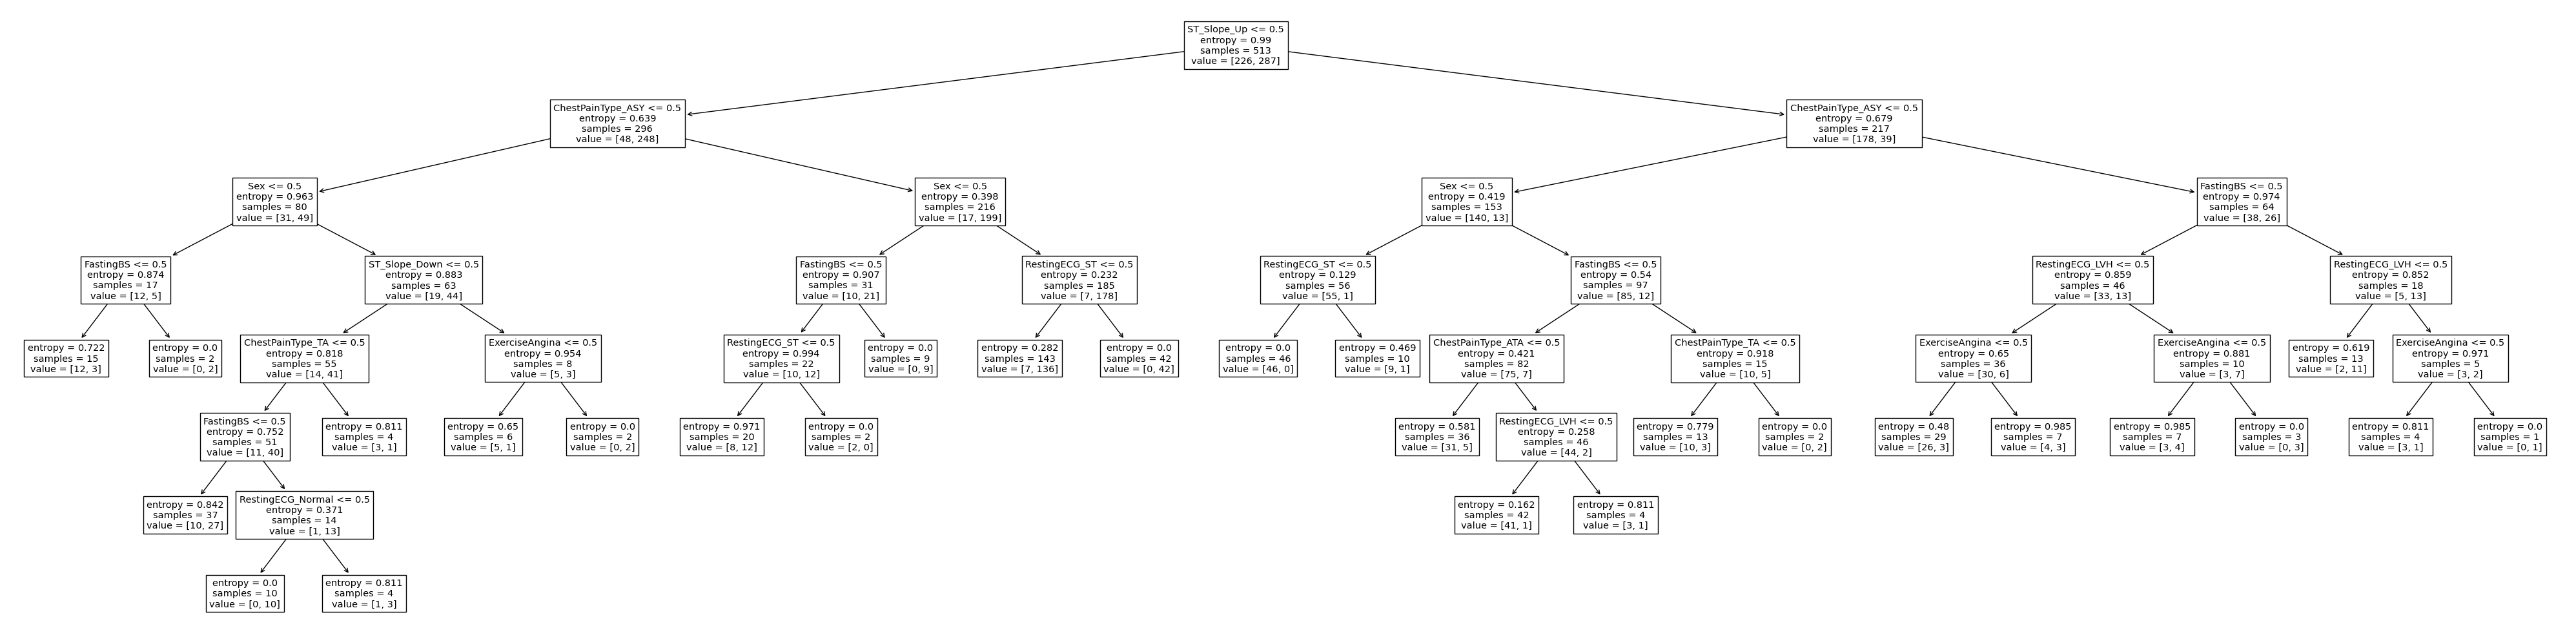

<class 'numpy.ndarray'>
 1) ST_Slope_Up                    0.550228
 2) ChestPainType_ASY              0.152004
 3) Sex                            0.083329
 4) FastingBS                      0.076899
 5) RestingECG_LVH                 0.037132
 6) ExerciseAngina                 0.031690
 7) RestingECG_ST                  0.024628
 8) ChestPainType_TA               0.022672
 9) ST_Slope_Down                  0.009636
10) RestingECG_Normal              0.006280
11) ChestPainType_ATA              0.005501
12) ST_Slope_Flat                  0.000000
13) ChestPainType_NAP              0.000000


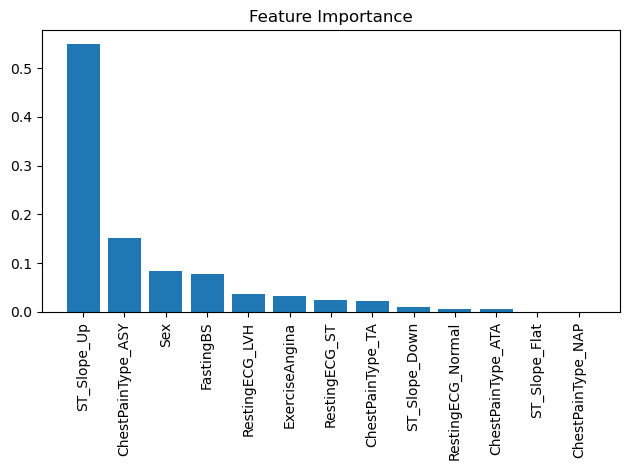

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,predict_svm,predict_proba_svm,predict_tree,predict_proba_tree
0,57.0,1.0,105.0,NaN,1.0,148.0,0.0,0.3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0.783905,1,0.750000
1,74.0,1.0,138.0,NaN,0.0,116.0,0.0,0.2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0.154608,0,0.138889
2,47.0,1.0,155.0,NaN,0.0,118.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0.822579,1,0.729730
3,44.0,1.0,130.0,233.0,0.0,179.0,1.0,0.4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0.108273,0,0.138889
4,43.0,0.0,120.0,249.0,0.0,176.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.021855,0,0.100000


In [26]:
# カテゴリ変数で決定木

cols_used, X_train, y_train, _, X_test, y_test, *_ = prepro(['HeartDisease', 'Sex', 'FastingBS', 'ExerciseAngina', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']
)

tree_model = DecisionTreeClassifier(criterion='entropy', random_state=1)
param1 = np.arange(1, 11)
param2 = np.arange(2, 31)
param3 = np.arange(1, 21)
param_grid = [{'max_depth': param1, 
               'max_leaf_nodes': param2,
               'min_samples_split': param3}]

# GridsearchCVクラスをインスタンス化: gsインスタンスを作成
gs = GridSearchCV(estimator=tree_model,
                  param_grid=param_grid, # ハイパーパラメータの候補を渡す
                  scoring='accuracy', # 正解率で競わせる
                  return_train_score=True,
                  cv=2, # 5分割で交差検証する
                  n_jobs=-1) # CPUをフルに使う
gs = gs.fit(X_train, y_train)
print('グリッドサーチのテスト用サブセットでの最良スコア:', gs.best_score_, '\nその時のパラメータ:', gs.best_params_)

tree_model = DecisionTreeClassifier(criterion='entropy', 
                                    max_depth=gs.best_params_['max_depth'],
                                    max_leaf_nodes=gs.best_params_['max_leaf_nodes'],
                                    min_samples_split=gs.best_params_['min_samples_split'],
                                    random_state=1)
tree_model.fit(X_train, y_train)

print('学習用データでの正解率:', (tree_model.predict(X_train) == y_train).mean())
print('テスト用データでの正解率:', (tree_model.predict(X_test) == y_test).mean())

plt.figure(figsize=(40, 10))
tree.plot_tree(tree_model, feature_names=cols_used, fontsize=10.5)
plt.tight_layout()
plt.show()

importances = tree_model.feature_importances_
indices = np.argsort(importances)[::-1]
print(type(indices))

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            cols_used[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')
plt.xticks(range(X_train.shape[1]), 
           cols_used[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

df['predict_tree'] = tree_model.predict(X_train)
df['predict_proba_tree'] = tree_model.predict_proba(X_train)[:, 1]
predict_proba_tree = tree_model.predict_proba(X_test)[:, 1]

df.head()

X_train.shape: (513, 2)
X_test.shape: (129, 2)
グリッドサーチのテスト用サブセットでの最良スコア: 0.7836287086575875 
その時のパラメータ: {'max_depth': 1, 'max_leaf_nodes': 2, 'min_samples_split': 1}
学習用データでの正解率: 0.783625730994152
テスト用データでの正解率: 0.7364341085271318


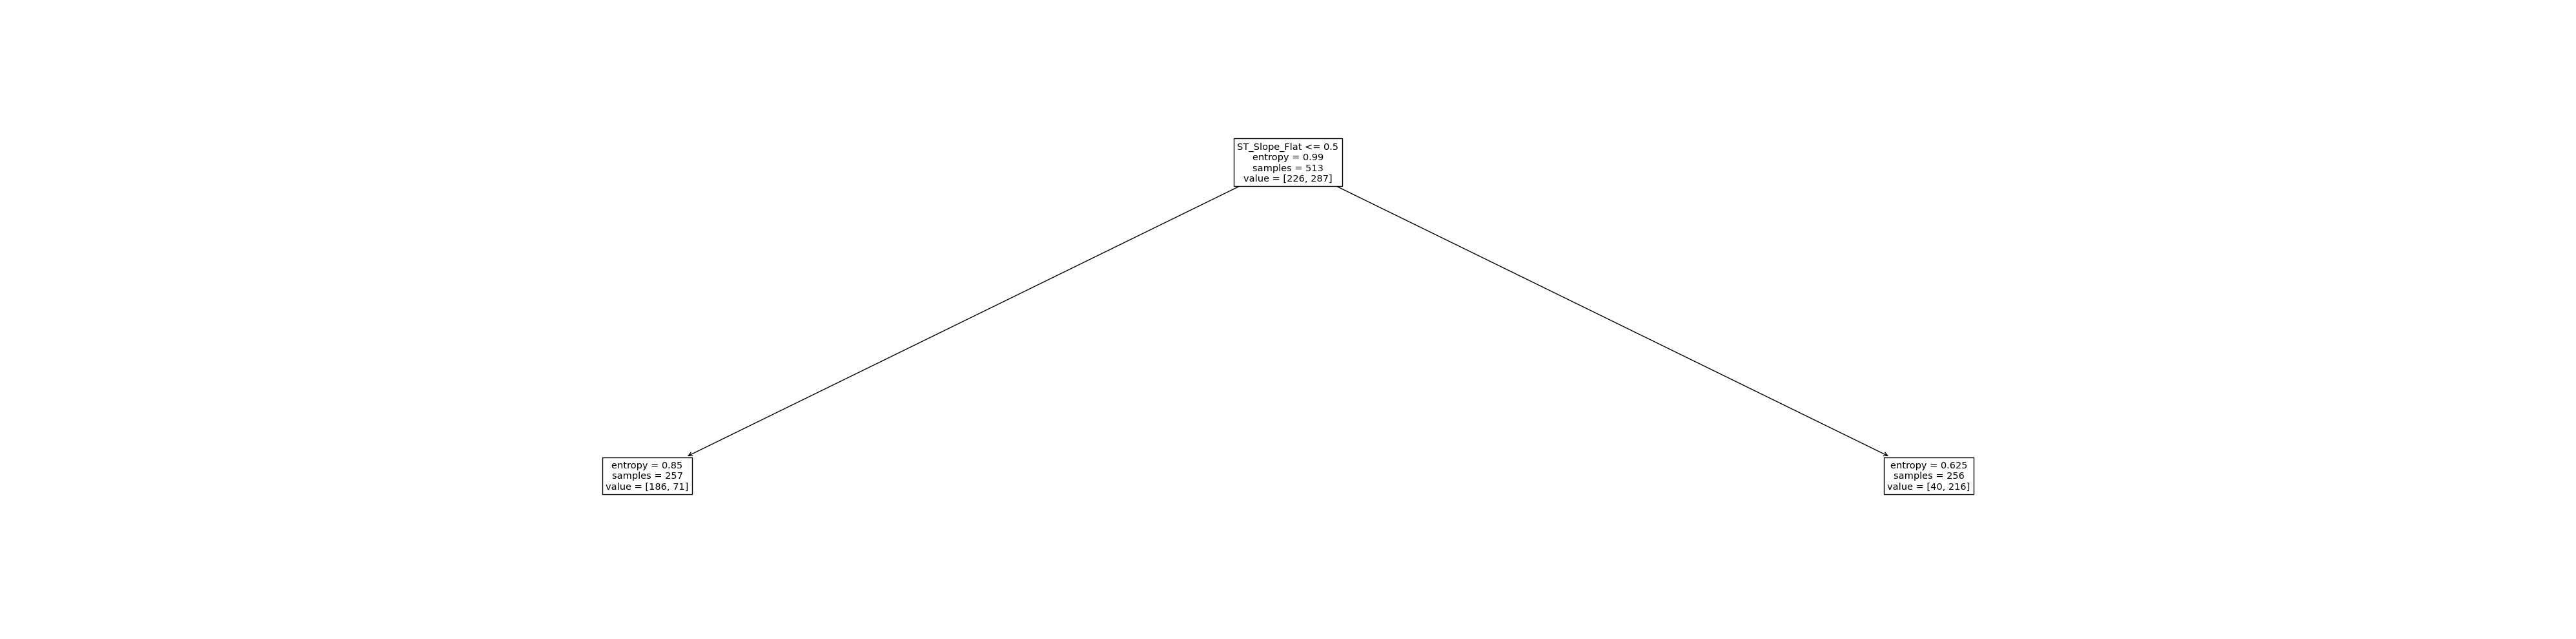

<class 'numpy.ndarray'>
 1) ST_Slope_Flat                  1.000000
 2) ChestPainType_NAP              0.000000


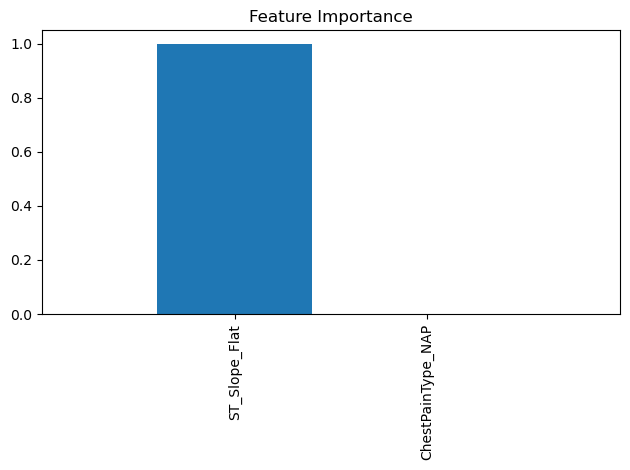

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,predict_svm,predict_proba_svm,predict_tree,predict_proba_tree,predict_tree2,predict_proba_tree2
0,57.0,1.0,105.0,NaN,1.0,148.0,0.0,0.3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0.783905,1,0.750000,1,0.843750
1,74.0,1.0,138.0,NaN,0.0,116.0,0.0,0.2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0.154608,0,0.138889,0,0.276265
2,47.0,1.0,155.0,NaN,0.0,118.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0.822579,1,0.729730,1,0.843750
3,44.0,1.0,130.0,233.0,0.0,179.0,1.0,0.4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0.108273,0,0.138889,0,0.276265
4,43.0,0.0,120.0,249.0,0.0,176.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.021855,0,0.100000,0,0.276265


In [27]:
# カテゴリ変数で決定木

cols_used, X_train, y_train, _, X_test, y_test, *_ = prepro(['HeartDisease', 'ChestPainType_NAP',  'ST_Slope_Flat'])

tree_model = DecisionTreeClassifier(criterion='entropy', random_state=1)
param1 = np.arange(1, 11)
param2 = np.arange(2, 31)
param3 = np.arange(1, 21)
param_grid = [{'max_depth': param1, 
               'max_leaf_nodes': param2,
               'min_samples_split': param3}]

# GridsearchCVクラスをインスタンス化: gsインスタンスを作成
gs = GridSearchCV(estimator=tree_model,
                  param_grid=param_grid, # ハイパーパラメータの候補を渡す
                  scoring='accuracy', # 正解率で競わせる
                  return_train_score=True,
                  cv=2, # 5分割で交差検証する
                  n_jobs=-1) # CPUをフルに使う
gs = gs.fit(X_train, y_train)
print('グリッドサーチのテスト用サブセットでの最良スコア:', gs.best_score_, '\nその時のパラメータ:', gs.best_params_)

tree_model = DecisionTreeClassifier(criterion='entropy', 
                                    max_depth=gs.best_params_['max_depth'],
                                    max_leaf_nodes=gs.best_params_['max_leaf_nodes'],
                                    min_samples_split=gs.best_params_['min_samples_split'],
                                    random_state=1)
tree_model.fit(X_train, y_train)

print('学習用データでの正解率:', (tree_model.predict(X_train) == y_train).mean())
print('テスト用データでの正解率:', (tree_model.predict(X_test) == y_test).mean())

plt.figure(figsize=(40, 10))
tree.plot_tree(tree_model, feature_names=cols_used, fontsize=10.5)
plt.tight_layout()
plt.show()

importances = tree_model.feature_importances_
indices = np.argsort(importances)[::-1]
print(type(indices))

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            cols_used[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')
plt.xticks(range(X_train.shape[1]), 
           cols_used[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

df['predict_tree2'] = tree_model.predict(X_train)
df['predict_proba_tree2'] = tree_model.predict_proba(X_train)[:, 1]
predict_proba_tree2 = tree_model.predict_proba(X_test)[:, 1]

df.head()

In [28]:
# SVMと決定木によるアンサンブル予測

df['predict_voted'] = df.apply(lambda x: 1 if (((x['predict_proba_svm'] + x['predict_proba_tree'] + x['predict_proba_tree']) / 3) >= 0.5) else 0, axis=1)
df['HeartDisease'] = y_train
print('学習用データでの正解率:', (df['predict_voted'] == df['HeartDisease']).mean())

df_test = pd.DataFrame({'predict_proba_svm': svm.predict_proba(X_test_ss)[:, 1],
                        'predict_proba_tree': predict_proba_tree,
                        'predict_proba_tree2': predict_proba_tree2})
df_test['predict_voted'] = df_test.apply(lambda x: 1 if (((x['predict_proba_svm'] + x['predict_proba_tree']) / 2) >= 0.5) else 0, axis=1)
df_test['HeartDisease'] = y_test
print('テスト用データでの正解率:', (df_test['predict_voted'] == df_test['HeartDisease']).mean())

学習用データでの正解率: 0.8966861598440545
テスト用データでの正解率: 0.8372093023255814


In [29]:
# 偽陽性、偽陰性の数はどれくらいか
df.groupby(['predict_voted', 'HeartDisease'], dropna=False).size() # .size()はNaNを含めてカウントする。.count()は含めないでカウントする。

predict_voted  HeartDisease
0              0               198
               1                25
1              0                28
               1               262
dtype: int64

In [30]:
# 2つのモデルの予測を比べる
df.groupby(['HeartDisease', 'predict_svm', 'predict_tree'], dropna=False).size()

HeartDisease  predict_svm  predict_tree
0             0            0               181
                           1                 4
              1            0                14
                           1                27
1             0            0                17
                           1                11
              1            0                 6
                           1               253
dtype: int64

In [31]:
# Cholesterolの欠損値について考える

# Cholesterolの欠損値について、データセット全体で、目的変数でgroup byすると: 
df0.groupby(['HeartDisease'], dropna=False).agg({'Cholesterol': lambda x: x.isnull().sum()})

,Cholesterol
HeartDisease,
0,12
1,111


In [32]:
# Cholesterolの欠損値について、学習用データセットで、目的変数と予測値でgroup byすると: 
df.groupby(['HeartDisease', 'predict_svm', 'predict_tree'], dropna=False).agg({'Cholesterol': lambda x: x.isnull().sum()})

Cholesterol
HeartDisease predict_svm predict_tree             
0            0           0                       7
                         1                       0
             1           0                       1
                         1                       2
1            0           0                       6
                         1                       5
             1           0                       1
                         1                      73

In [33]:
# 真陰性、偽陰性、偽陽性、真陽性のそれぞれの説明変数の平均と標準偏差
df.groupby(['predict_voted', 'HeartDisease'], dropna=False).agg(['mean', 'min', 'max'])

Age                   Sex            \
                                 mean   min   max      mean  min  max   
predict_voted HeartDisease                                              
0             0             49.696970  28.0  76.0  0.601010  0.0  1.0   
              1             57.200000  38.0  74.0  0.760000  0.0  1.0   
1             0             53.821429  37.0  71.0  0.714286  0.0  1.0   
              1             56.091603  32.0  77.0  0.908397  0.0  1.0   

                             RestingBP               Cholesterol         \
                                  mean    min    max        mean    min   
predict_voted HeartDisease                                                
0             0             131.116162   94.0  180.0  237.463158   85.0   
              1             132.360000  108.0  160.0  253.500000  203.0   
1             0             127.107143   80.0  180.0  258.000000  149.0   
              1             135.122137   95.0  200.0  251.565217  100.0   

                                  FastingBS                 MaxHR        \
                              max      mean  min  max        mean   min   
predict_voted HeartDisease                                                
0             0             468.0  0.106061  0.0  1.0  150.803030  86.0   
              1             335.0  0.160000  0.0  1.0  154.080000  97.0   
1             0             458.0  0.142857  0.0  1.0  136.000000  69.0   
              1             603.0  0.370229  0.0  1.0  125.950382  67.0   

                                  ExerciseAngina             Oldpeak       \
                              max           mean  min  max      mean  min   
predict_voted HeartDisease                                                  
0             0             194.0       0.080808  0.0  1.0  0.239394 -0.1   
              1             182.0       0.160000  0.0  1.0  0.964000  0.0   
1             0             165.0       0.571429  0.0  1.0  1.021429  0.0   
              1             176.0       0.648855  0.0  1.0  1.369466 -2.6   

                                ChestPainType_ASY           ChestPainType_ATA  \
                            max              mean  min  max              mean   
predict_voted HeartDisease                                                      
0             0             2.0          0.191919  0.0  1.0          0.449495   
              1             3.8          0.360000  0.0  1.0          0.200000   
1             0             3.0          0.607143  0.0  1.0          0.071429   
              1             6.2          0.824427  0.0  1.0          0.034351   

                                     ChestPainType_NAP            \
                            min  max              mean  min  max   
predict_voted HeartDisease                                         
0             0             0.0  1.0          0.308081  0.0  1.0   
              1             0.0  1.0          0.360000  0.0  1.0   
1             0             0.0  1.0          0.321429  0.0  1.0   
              1             0.0  1.0          0.129771  0.0  1.0   

                           ChestPainType_TA           RestingECG_LVH       \
                                       mean  min  max           mean  min   
predict_voted HeartDisease                                                  
0             0                    0.050505  0.0  1.0       0.166667  0.0   
              1                    0.080000  0.0  1.0       0.320000  0.0   
1             0                    0.000000  0.0  0.0       0.285714  0.0   
              1                    0.011450  0.0  1.0       0.167939  0.0   

                                RestingECG_Normal           RestingECG_ST  \
                            max              mean  min  max          mean   
predict_voted HeartDisease                                                  
0             0             1.0          0.676768  0.0  1.0      0.156566   
              1             1.0      

In [34]:
df.groupby([ 'HeartDisease'], dropna=False).agg(['mean', 'min', 'max'])

Age                   Sex             RestingBP        \
                   mean   min   max      mean  min  max        mean   min   
HeartDisease                                                                
0             50.207965  28.0  76.0  0.615044  0.0  1.0  130.619469  80.0   
1             56.188153  32.0  77.0  0.895470  0.0  1.0  134.881533  95.0   

                    Cholesterol               FastingBS                 MaxHR  \
                max        mean    min    max      mean  min  max        mean   
HeartDisease                                                                    
0             180.0  239.935185   85.0  468.0  0.110619  0.0  1.0  148.969027   
1             200.0  251.737624  100.0  603.0  0.351916  0.0  1.0  128.400697   

                          ExerciseAngina             Oldpeak            \
               min    max           mean  min  max      mean  min  max   
HeartDisease                                                             
0             69.0  194.0       0.141593  0.0  1.0  0.336283 -0.1  3.0   
1             67.0  182.0       0.606272  0.0  1.0  1.334146 -2.6  6.2   

             ChestPainType_ASY           ChestPainType_ATA            \
                          mean  min  max              mean  min  max   
HeartDisease                                                           
0                     0.243363  0.0  1.0          0.402655  0.0  1.0   
1                     0.783972  0.0  1.0          0.048780  0.0  1.0   

             ChestPainType_NAP           ChestPainType_TA            \
                          mean  min  max             mean  min  max   
HeartDisease                                                          
0                     0.309735  0.0  1.0         0.044248  0.0  1.0   
1                     0.149826  0.0  1.0         0.017422  0.0  1.0   

             RestingECG_LVH           RestingECG_Normal            \
                       mean  min  max              mean  min  max   
HeartDisease                                                        
0                  0.181416  0.0  1.0          0.672566  0.0  1.0   
1                  0.181185  0.0  1.0          0.595819  0.0  1.0   

             RestingECG_ST           ST_Slope_Down           ST_Slope_Flat  \
                      mean  min  max          mean  min  max          mean   
HeartDisease                                                                 
0                 0.146018  0.0  1.0      0.035398  0.0  1.0      0.176991   
1                 0.222997  0.0  1.0      0.111498  0.0  1.0      0.752613   

                       ST_Slope_Up           predict_svm          \
              min  max        mean  min  max        mean min max   
HeartDisease                                                       
0             0.0  1.0    0.787611  0.0  1.0    0.181416   0   1   
1             0.0  1.0    0.135889  0.0  1.0    0.902439   0   1   

             predict_proba_svm                     predict_tree          \
                          mean       min       max         mean min max   
HeartDisease                                                              
0                     0.231745  0.014794  0.957776     0.137168   0   1   
1                     0.827471  0.048898  0.989322     0.919861   0   1   

             predict_proba_tree                    predict_tree2          \
                           mean      min       max          mean min max   
HeartDisease                                                               
0                       0.18269  0.00000  0.951049      0.176991   0   1   
1                       0.85614  0.02381  1.000000      0.752613   0   1   

             predict_proba_tree2                    predict_voted          
                            mean       min      max          mean min max  
HeartDisease                                                               
0                       0.376704  0.276265  0.84375      0.123894   0   1  
1

# 因子分析してみた

In [35]:
# 因子数を指定
n_components=3

# 因子分析の実行
fa = FA(n_components, max_iter=5000)

cols_used, _, y_train, X_train_ss, _, y_test, X_test_ss = prepro()

fitted = fa.fit_transform(X_train_ss)

# データフレームに変換
df_fa = pd.DataFrame(fa.components_.T, 
             columns=["第1因子", "第2因子", "第3因子"], 
             index=cols_used)

display(df_fa.style.background_gradient())

X_train.shape: (513, 17)
X_test.shape: (129, 17)


,第1因子,第2因子,第3因子
Age,-0.243758,0.130950,0.207047
Sex,-0.170881,0.082708,-0.010559
RestingBP,-0.110312,-0.018655,0.127918
FastingBS,-0.122236,0.077183,0.067685
MaxHR,0.411406,-0.095070,0.034959
ExerciseAngina,-0.458220,0.218497,0.018737
Oldpeak,-0.352930,0.367100,0.110922
ChestPainType_ASY,-0.402986,0.156309,0.012827
ChestPainType_ATA,0.390826,-0.117855,-0.065166
ChestPainType_NAP,0.092831,-0.053608,0.038702


# Cholesterolの数値予測してみた

In [36]:
having_cholesterol = df1[~df1['Cholesterol'].isna()]
missing_cholesterol = df1[df1['Cholesterol'].isna()]

y_having_cholesterol = having_cholesterol['Cholesterol']
X_having_cholesterol = having_cholesterol.drop(columns=['HeartDisease', 'Cholesterol'])

sscaler = StandardScaler()
X_having_cholesterol_ss = sscaler.fit_transform(X_having_cholesterol)

X_train_having_cholesterol_ss, X_test_having_cholesterol_ss, y_train_having_cholesterol, y_test_having_cholesterol = train_test_split(X_having_cholesterol_ss, y_having_cholesterol, test_size=0.2, random_state=1)

alpha 2.511886431509469
切片 244.04025288219094


,説明変数,係数
0,Age,1.236936
1,Sex,-3.385733
2,RestingBP,2.147426
3,FastingBS,2.728014
4,MaxHR,-0.000000
5,ExerciseAngina,0.000000
6,Oldpeak,0.000000
7,ChestPainType_ASY,1.053351
8,ChestPainType_ATA,0.000000
9,ChestPainType_NAP,-3.728338


,Cholesterol,Cholesterol_predicted
338,224.000000,247.958660
337,529.000000,244.259345
407,342.000000,247.883186
597,283.000000,253.278982
212,230.000000,260.705985
79,308.000000,235.964576
287,123.000000,261.863214
180,193.000000,251.539833
460,241.000000,248.674240
331,159.000000,235.148896


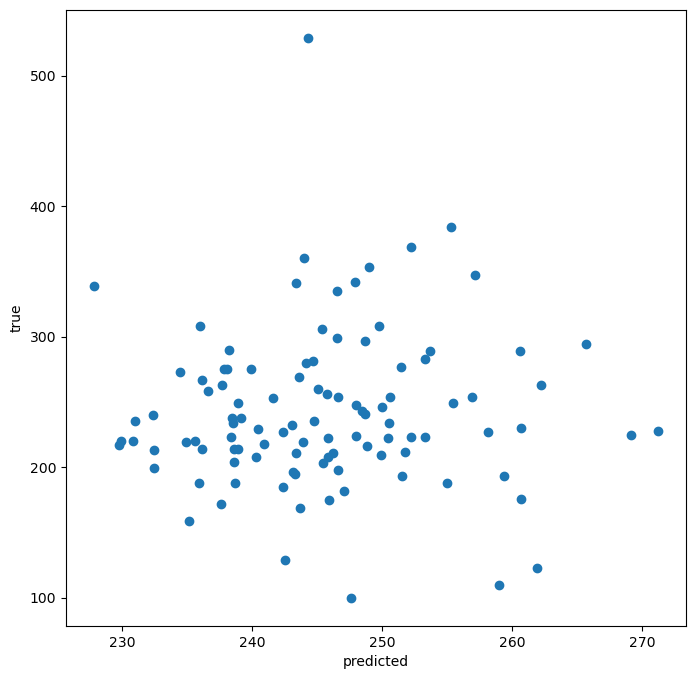

In [39]:
linear_lasso_cv = LassoCV(alphas=10 ** np.arange(-5, 5, 0.1), cv=3)
linear_lasso_cv.fit(X_train_having_cholesterol_ss, y_train_having_cholesterol)
print('alpha', linear_lasso_cv.alpha_)
print('切片', linear_lasso_cv.intercept_)
display(pd.DataFrame({'説明変数': X_having_cholesterol.columns,
                      '係数': linear_lasso_cv.coef_}))
display(pd.DataFrame({'Cholesterol': y_test_having_cholesterol,
                      'Cholesterol_predicted': linear_lasso_cv.predict(X_test_having_cholesterol_ss)}).head(20).style.background_gradient())

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(linear_lasso_cv.predict(X_test_having_cholesterol_ss), y_test_having_cholesterol)
ax.set_xlabel('predicted')
ax.set_ylabel('true')
# ax.set_aspect('equal')

plt.show()

In [40]:
display(df1[df1['Cholesterol'] >= 394])
print('コレステロール値上位{}人のうちHeartDiseaseが1の人の割合:'.format(np.shape(df1[df1['Cholesterol'] >= 333]['HeartDisease'])[0]), np.mean(df1[df1['Cholesterol'] >= 333]['HeartDisease']))

,HeartDisease,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
1,0,55,0,130,394.0,0,150,0,0.0,0,1,0,0,1,0,0,0,0,1
133,0,65,0,140,417.0,1,157,0,0.8,0,0,1,0,1,0,0,0,0,1
141,0,53,0,113,468.0,0,127,0,0.0,0,1,0,0,0,1,0,0,0,1
147,0,44,1,150,412.0,0,170,0,0.0,1,0,0,0,0,1,0,0,0,1
213,0,62,0,140,394.0,0,157,0,1.2,1,0,0,0,1,0,0,0,1,0
244,1,54,1,130,603.0,1,125,1,1.0,1,0,0,0,0,1,0,0,1,0
318,0,58,1,132,458.0,1,69,0,1.0,1,0,0,0,0,1,0,1,0,0
337,1,32,1,118,529.0,0,130,0,0.0,1,0,0,0,0,1,0,0,1,0
496,1,52,1,140,404.0,0,124,1,2.0,1,0,0,0,0,1,0,0,1,0
502,1,44,1,135,491.0,0,135,0,0.0,1,0,0,0,0,1,0,0,1,0


コレステロール値上位30人のうちHeartDiseaseが1の人の割合: 0.6


In [41]:
# 総コレステロールが400超えてても半数近くが病気該当じゃない時点で、コレステロールは説明変数として使い物にならない
# 何か特殊な病気がターゲットになっている

In [42]:
display(df1[df1['Cholesterol'] <= 131])
print('コレステロール値下位{}人のうちHeartDiseaseが1の人の割合:'.format(np.shape(df1[df1['Cholesterol'] <= 166]['HeartDisease'])[0]), np.mean(df1[df1['Cholesterol'] <= 166]['HeartDisease']))

,HeartDisease,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
13,1,56,1,120,100.0,0,120,1,1.5,1,0,0,0,0,1,0,0,1,0
40,1,57,1,130,131.0,0,115,1,1.2,1,0,0,0,0,1,0,0,1,0
155,0,50,1,140,129.0,0,135,0,0.0,1,0,0,0,0,1,0,0,0,1
222,1,59,1,130,126.0,0,125,0,0.0,1,0,0,0,0,1,0,0,1,0
287,1,72,1,160,123.0,1,130,0,1.5,1,0,0,0,1,0,0,0,1,0
306,1,38,1,92,117.0,0,134,1,2.5,1,0,0,0,0,1,0,0,1,0
472,0,56,1,120,85.0,0,140,0,0.0,1,0,0,0,0,1,0,0,0,1
481,0,52,1,140,100.0,0,138,1,0.0,0,1,0,0,0,1,0,0,0,1
539,1,69,1,140,110.0,1,109,1,1.5,1,0,0,0,0,1,0,0,1,0
562,0,57,1,150,126.0,1,173,0,0.2,0,0,1,0,0,1,0,0,0,1


コレステロール値下位29人のうちHeartDiseaseが1の人の割合: 0.41379310344827586


# HistGradientBoostingClassifier試してみた

In [43]:
hgbc = HistGradientBoostingClassifier(loss='log_loss')

# param_grid = [{
#     'learning_rate': [0.01, 0.1, 1],
#     'max_iter': [10, 100, 1000],
#     'max_depth': [2, 3, 4, 5, 6, None], 
#     'max_leaf_nodes': [9, 16, 31, None],
#     'min_samples_leaf': [10, 16, 22],
#     'l2_regularization': [0, 0.001, 0.01, 0.1]
#               }]

param_grid = [{
    'max_depth': np.arange(1, 8, 1), 
    'max_leaf_nodes': np.arange(2, 25, 1),
    'min_samples_leaf': np.arange(1, 20, 1)
              }]

gs = GridSearchCV(estimator=hgbc,
                  param_grid=param_grid, # ハイパーパラメータの候補を渡す
                  scoring='accuracy', # 正解率で競わせる
                  return_train_score=True,
                  cv=3, # 5分割で交差検証する
                  n_jobs=-1) # CPUをフルに使う

cols_used, _, y_train, X_train_ss, _, y_test, X_test_ss = prepro()
gs = gs.fit(X_train_ss, y_train)
print('グリッドサーチのテスト用サブセットでの最良スコア:', gs.best_score_, '\nその時のパラメータ:', gs.best_params_)

X_train.shape: (513, 17)
X_test.shape: (129, 17)
グリッドサーチのテスト用サブセットでの最良スコア: 0.871345029239766 
その時のパラメータ: {'max_depth': 2, 'max_leaf_nodes': 3, 'min_samples_leaf': 8}


In [44]:
# hgbc = HistGradientBoostingClassifier(
#     loss='log_loss',
#     l2_regularization=0,
#     learning_rate=1, 
#     max_depth=2,
#     max_iter=10,
#     max_leaf_nodes=9,
#     min_samples_leaf=10
# )
hgbc = HistGradientBoostingClassifier(
    loss='log_loss',
    learning_rate=0.1,
    max_depth=2,
    max_leaf_nodes=3,
    min_samples_leaf=8
)
hgbc.fit(X_train_ss, y_train)
print('学習正解率', np.mean(hgbc.predict(X_train_ss) == y_train))
print('テスト正解率', np.mean(hgbc.predict(X_test_ss) == y_test))

学習正解率 0.9161793372319688
テスト正解率 0.8449612403100775
